# Statistical Foundations of Machine Learning: Project

## Introduction
This notebook was created as part of the coursework for Statistical Foundations of Machine Learning, a master's course in Artificial Intelligence at the VUB (Vrije Universiteit Brussel). In this interactive notebook we will try to answer 3 research questions by applying ML algorithms to both synthetic and real datasets.

Running the cell below will install the following packages: 
- numpy
- matplotlib
- scipy
- scikit-learn
- pandas
**WARNING: Our notebook uses an older version (0.24.1) of scikit-learn**

In [ ]:
import sys, os
sys.prefix
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install scikit-learn==0.24.1
!{sys.executable} -m pip install numpy matplotlib scipy pandas scikit-multilearn opendatasets seaborne 
#!pip uninstall scikit-learn -y

The cell below will download the datasets used in this notebook. 2 of our datasets are from *kaggle.com*. To download these, you will be prompted to enter your kaggle username and API-key.

In [140]:
import opendatasets as od
import requests

# !!! ---------------------------------------------------------------------------!!!
# Download the imbalanced data dataset (enter your kaggle username and API key when prompted)
# This process may take a minute 
if not os.path.exists('imbalanced-data-practice/aug_test.csv'):
    od.download("https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice?select=aug_train.csv")

# !!! ---------------------------------------------------------------------------!!!
# Download the possum dataset (enter your kaggle username and API key when prompted)
# This process may take a minute 
if not os.path.exists("openintro-possum/possum.csv"):
    od.download("https://www.kaggle.com/datasets/abrambeyer/openintro-possum")

# Download foodtruck dataset
if not os.path.exists('foodtruck/foodtruck.arff'):
    r = requests.get('https://old.openml.org/data/v1/download/18631086/food-truck-test.arff')
    os.mkdir("./foodtruck")
    open('./foodtruck/foodtruck.arff', 'wb').write(r.content)

# Download MLSMOTE
!git clone https://github.com/niteshsukhwani/MLSMOTE.git

Cloning into 'MLSMOTE'...


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklRunning the cell below will install the following packages: 
- numpy
- matplotlib
- scipy
- scikit-learn
- pandas
**WARNING: Our notebook uses an older version (0.24.1) of scikit-learn**

import sys, os
sys.prefix
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install scikit-learn==0.24.1
!{sys.executable} -m pip install numpy matplotlib scipy pandas scikit-multilearn opendatasets seaborne 
#!pip uninstall scikit-learn -y

The cell below will download the datasets used in this notebook. 2 of our datasets are from *kaggle.com*. To download these, you will be prompted to enter your kaggle username and API-key.

import opendatasets as od
import requests

# !!! ---------------------------------------------------------------------------!!!
# Download the imbalanced data dataset (enter your kaggle username and API key when prompted)
# This process may take a minute 
if not os.path.exists('imbalanced-data-practice/aug_test.csv'):
    od.download("https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice?select=aug_train.csv")

# !!! ---------------------------------------------------------------------------!!!
# Download the possum dataset (enter your kaggle username and API key when prompted)
# This process may take a minute 
if not os.path.exists("openintro-possum/possum.csv"):
    od.download("https://www.kaggle.com/datasets/abrambeyer/openintro-possum")

# Download foodtruck dataset
if not os.path.exists('foodtruck/foodtruck.arff'):
    r = requests.get('https://old.openml.org/data/v1/download/18631086/food-truck-test.arff')
    os.mkdir("./foodtruck")
    open('./foodtruck/foodtruck.arff', 'wb').write(r.content)

# Download MLSMOTE
!git clone https://github.com/niteshsukhwani/MLSMOTE.git
import pandas as pd
from scipy import stats
import scipy as sp
import opendatasets as od
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets, metrics, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from math import floor
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from warnings import simplefilter
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import make_scorer, f1_score, hamming_loss
from skmultilearn.adapt import MLkNN

## Research Question 1

The first question proposed in this notebook concentrates on the influence of class imbalance on the quality of feature selection using Pearson's correlation. Class imbalance in classification tasks is a common problem, luckily several methods exist to tackle this issue. Such methods include upsampling/oversampling and downsampling/undersampling. When used in combination with feature selection, we could ask ourselves whether we should perform the upsampling/downsampling before or after the feature selection is performed. This question specifically focuses on the Pearson's correlation feature selection method. This notebook will start of by covering some background on the Pearson's correlation feature selection method, showing why it proves to be interesting given the context of imbalanced classes. Afterwards, synthetic datasets with varying levels of class imbalance are used to test our suspicions. In order to keep things simple, only a single binary label is considered. Finally, our experimental setup is repeated on a real-world imbalanced dataset.

### Pearson's correlation

In case of classification, we may use Pearson's correlation during feature selection by calculating the correlation between each input feature and the target label. Afterwards, features with an absolute value of the correlation lower than some predefined threshold may be dropped as they have insufficient impact on the prediction of the label and add up to the model complexity. The Pearson's correlation between an input feature and the target label can be calculated using the following formula: <br><br>

$$ r = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2}
\sqrt{\sum_{i=1}^n (y_i - \bar{y})^2}} $$

$x_i =$ sample of input feature $x$ <br>
$\bar{x} =$ mean of values of a input feature $x$ <br>
$y_i =$ sample of target labels $y$ <br>
$\bar{y} =$ mean of values of target labels <br>

Since the given formula is dependent on the mean value of the target labels and class imbalance causes this mean value to shift heavily towards either 1 or 0 (in case of two labels), we may suspect that class imbalance could affect the outcome of the calculated correlations.

### Algorithms

#### SVC

The first algorithm used in our experimental setup is support vector classifier (SVC).

Let $x = \{x_i | 1 \leq i \leq N\}$ be the features of our training samples and $y = \{y_i | 1 \leq i \leq N\}$ their target values. The soft-margin SVC learns the following hypothesis:

$$ g(x) = sign(\sum_{\alpha_n>0}\alpha_n y_n K(x_n,x) + b) \;\;\; [1]$$

The function $K$ represent a kernel method of choice. We may obtain the $\alpha_n$ by minimizing the following:

$$ \frac{1}{2} w^T w + C \sum_{n=1}^{N} \xi_n \;\;\; [2]$$

Here, the first term corresponds to maximizing the margin, the second term corresponds to minimizing the total violations. A violation occurs when a training point falls within the margins.

$$y_n(w^T x_n + b) < 1$$

While maximizing the margin, training points should lie outside the margins (except for the few violations). Therefore, the following constraints are added to minimizing $[2]$:

$$y_n(w^T x_n + b) \geq 1-\xi_n \;\;\; \forall n = 1,...,N$$ 
$$\xi_n \geq 0 \;\;\; \forall n = 1,...,N$$ 
$$w \in \mathbb{R}^d, b \in \mathbb{R}, \xi \in \mathbb{R}^N$$

We can minimize $[2]$ given its constraints through the saddle points of the Lagrange’s function:
   
$$L(w,b,\xi,\alpha,\beta) = \frac{1}{2} w^T w + C \sum_{n=1}^{N}\xi_n - \sum_{n=1}^{N}\alpha_n(y_n(w^T x_n + b) - 1 + \xi_n) - \sum_{n=1}^{N}\beta_n \xi_n$$

Minimizing the Lagrange function with respect to $w$, $b$, and $\xi$ gives:

$$L(\alpha) = \sum_{n=1}^{N}\alpha_n - \frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{M} y_n y_m \alpha_n \alpha_m x_n^T x_m^T \;\;\; [3]$$

Subject to:

$$0 \leq \alpha_n \leq C \;\;\; \forall n=1,...,N$$
$$and \sum_{n=1}^{N}\alpha_n y_n = 0$$

We may maximize $[3]$ through the use of quadratic programming. The resulting $\alpha_n$ minimize $[2]$ and hence result in $[1]$. The support vectors of the resulting hypothesis are the $x_n$ for which $0 < \alpha_n < C$. 
<br> <br> 
#### KNN
A K-Nearest-Neighbour (KNN) algorithm predicts the value for a point based on the points it is close to, its neighbours. Specifically, these algorithms provide the user with a tunable hyperparameter $k$ which determines how many of these neighbours we want to take into account.

A KNN classifier classifies a point as the majority label among its $k$ neighbours. Let $\{d_i | 1 \leq i \leq k\}$ be the $k$ training samples nearest to $x$ and $y = \{y_i | 1 \leq i \leq k\}$ their classifications.
$$  
    F(x) = sign(\sum_{i=1}^k y_i)
$$


### Synthetic data

First, we will use synthetic data in order to test the impact of performing feature selection using Pearson's correlation on imbalanced data. To start off, multiple datasets are created, ranging from a very imbalanced dataset (99-1 ratio) to a balanced dataset (50-50 ratio). Afterwards, feature selection will be performed on each dataset in its original state as well [1] as after it is upscaled/downscaled [2]. Finally, SVC and KNN models will be trained on the datasets (after they were upscaled/downscaled) with no feature selection, features selected by [1] and lastly features selected by [2].  

The following code generates the datasets used in our experimental setup. The plots visualize the imbalance in each dataset. Note that we only account for datasets where the label 1 ('yes') is a minority compared to label 0. This means our mean value of the target labels will approach 0. The roles in our experimental setup can however easily be reversed. This won't be covered in this notebook since the conclusion that can be drawn in both cases are similar.

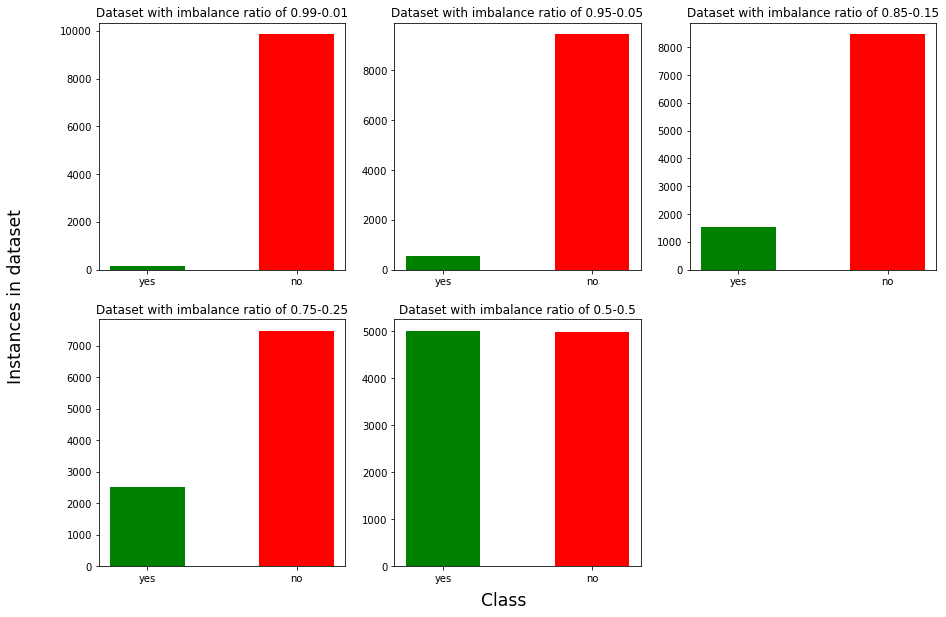

In [4]:
# Create (imbalanced) synthetic datasets

datasets_per_balance = []
initial_testing_datasets_per_balance = []

fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.delaxes(axs[1][2])
fig.text(0.5, 0.07, 'Class', ha='center', fontsize='xx-large')
fig.text(0.04, 0.5, 'Instances in dataset', va='center', rotation='vertical', fontsize='xx-large')

for ctr, balance in enumerate([0.99, 0.95, 0.85, 0.75, 0.5]):
    data = datasets.make_classification(n_samples=10000, n_features=10, n_informative=4, weights=[balance, 1-balance], random_state=123)
    synthetic_data_x = pd.DataFrame(data[0])
    synthetic_data_y = pd.DataFrame(data[1])
    synthetic_data_y.columns = ["Label"]
    synthetic_data_x_train, synthetic_data_x_test, synthetic_data_y_train, synthetic_data_y_test = train_test_split(synthetic_data_x, synthetic_data_y, test_size=0.3,random_state=44)
    datasets_per_balance = datasets_per_balance + [[pd.concat([synthetic_data_x_train, synthetic_data_y_train], axis=1)]]
    initial_testing_datasets_per_balance = initial_testing_datasets_per_balance + [[pd.concat([synthetic_data_x_test, synthetic_data_y_test], axis=1)]]
    imbalance = [synthetic_data_y[synthetic_data_y['Label']==1].count()["Label"],
                 synthetic_data_y[synthetic_data_y['Label']==0].count()["Label"]]
    classes = ['yes', 'no']
    axs[floor(ctr/3), ctr%3].bar(classes, imbalance, width=0.5, color=['green', 'red'])
    axs[floor(ctr/3), ctr%3].title.set_text("Dataset with imbalance ratio of " + str(balance) + "-" + str(round(1-balance, 2)))

Now that the datasets have been generated, we will create an upsampled and a downsampled copy of each dataset. When upsampling, instances of the minority class (in this case "1") will be duplicated such that we have a near equal amount of instances of both classes. As a result, the size of our dataset increases. In case of downsampling, instances of the majority class (in this case "0") are removed until we have a near equal amount of instances of both classes. As a result, the size of our dataset decreases. We now have access to the original datasets, balanced upsampled versions of each dataset and lastly balanced upsampled versions of each dataset. 

In [5]:
for ctr, synthetic_data in enumerate(datasets_per_balance):
    synthetic_data = synthetic_data[0]

    majority = synthetic_data[synthetic_data["Label"]==0]
    minority = synthetic_data[synthetic_data["Label"]==1]

    min_amount = len(minority)
    maj_amount = len(majority)
    
    if min_amount < maj_amount:
        majority_downsampled = resample(majority, replace=False, n_samples=min_amount, random_state=123) 
        minority_upsampled = resample(minority, replace=True, n_samples=maj_amount, random_state=123) 

        downsampled_dataset = pd.concat([majority_downsampled, minority])
        upsampled_dataset = pd.concat([minority_upsampled, majority])
        datasets_per_balance[ctr] = datasets_per_balance[ctr] + [downsampled_dataset, upsampled_dataset]
    else:
        datasets_per_balance[ctr] = datasets_per_balance[ctr] + datasets_per_balance[ctr]     

Now that we have three variants for each dataset, we can calculate the Pearson's correlations for each of those variants. The Pearson's correlations for the three variants of the dataset with an initial imbalance of 85-15 are shown below. We may notice that for the balanced variants of the dataset, the correlations of the significant features (such as feature 0 and 8) have a higher absolute value than they do in case of the original unbalanced dataset. Generally, the higher the imbalance of the original dataset, the greater the differences in absolute value will be compared to the balanced variants.

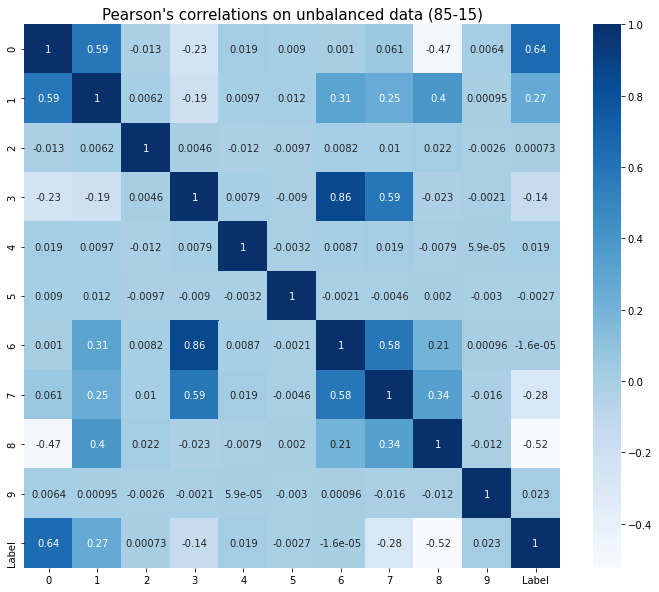

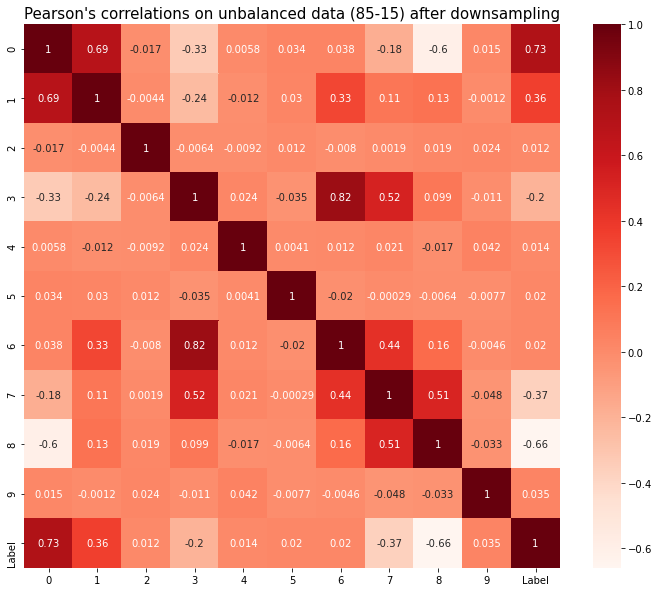

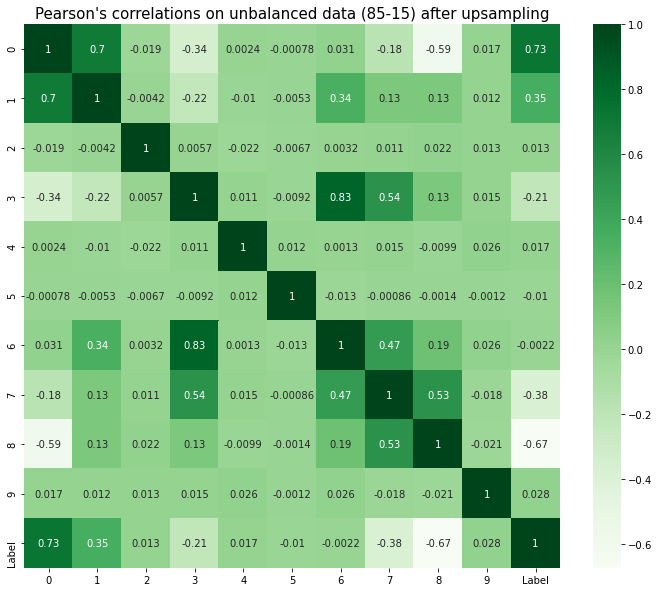

In [6]:
titles = ["Pearson's correlations on unbalanced data (85-15)",
         "Pearson's correlations on unbalanced data (85-15) after downsampling",
         "Pearson's correlations on unbalanced data (85-15) after upsampling"]
colors = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
correlations = []

for ctr, synthetic_data in enumerate(datasets_per_balance[2]):
    plt.figure(ctr, figsize=(12,10))
    plt.title(titles[ctr], fontsize=15)
    correlations = correlations + [synthetic_data.corr()]
    sns.heatmap(correlations[ctr], annot=True, cmap=colors[ctr])
    plt.show()

Now that we have access to the Pearson's correlations, we may drop features if the absolute value of their correlation does not exceed a certain threshold. A threshold of 0.3 is chosen for our experimental setup. As we may see below, the correlations calculated before the balancing of the dataset, lead to the exclusion of more features than is the case with the datasets after upsampling/downsampling. This is due to the absolute values of the correlations in case of imbalance being smaller as discussed earlier. This proves our suspicions that imbalance does affect feature selection using Pearson's correlations. We may still ask ourselves whether the features selected by the balanced datasets result in a higher accuracy for a given model than the features selected by the imbalanced datasets and whether the degree of imbalance of the dataset has a significant influence.

In [7]:
for ctr, corr in enumerate(correlations):
    print(titles[ctr])
    target = abs(corr["Label"])
    relevant_features = target[target>0.3]
    print(relevant_features)
    print("---------------------------")

Pearson's correlations on unbalanced data (85-15)
0        0.643408
8        0.523996
Label    1.000000
Name: Label, dtype: float64
---------------------------
Pearson's correlations on unbalanced data (85-15) after downsampling
0        0.732957
1        0.361037
7        0.366406
8        0.659918
Label    1.000000
Name: Label, dtype: float64
---------------------------
Pearson's correlations on unbalanced data (85-15) after upsampling
0        0.731882
1        0.348671
7        0.377213
8        0.671975
Label    1.000000
Name: Label, dtype: float64
---------------------------


The following code select features for each dataset, based on the Pearson's correlations for that dataset.

In [8]:
relevant_features = []

for ctr, synthetic_datasets in enumerate(datasets_per_balance):
    relevant_features = relevant_features + [[]]
    for synthetic_data in synthetic_datasets:
        corr = synthetic_data.corr()
        target = abs(corr["Label"])
        relevant_features_for_this_dataset = target[target>0.3]
        relevant_features[ctr] = relevant_features[ctr] + [relevant_features_for_this_dataset]

The following code drops the irrelevant features from the training and test sets. We no longer keep track of the original imbalanced datasets as we do not want to train our models on these datasets (due to their imbalance) and we no longer require them since the feature selection process has been finished. Our final datasets are setup as follows: <br><br>
-  An upsampled/downsampled version of each original dataset<br>
$\;$-  For each of these datasets we have:<br>
$\;\;\;$- a training set on which no feature selection is performed<br>
$\;\;\;$- a training set on which feature selection is performed based on the correlations before the sampling<br>
$\;\;\;$- a training set on which feature selection is performed based on the correlations after the sampling<br><br>
            
It is in our interest to compare the accuracy of models on the last two training sets as they will showcase the impact of performing feature selection using Pearson's correlations before and after the balancing of the dataset.

In [9]:
training_datasets_per_balance = []
testing_datasets_per_balance = []

for idx1, synthetic_datasets in enumerate(datasets_per_balance):
    training_datasets_per_balance += [[]]
    testing_datasets_per_balance += [[]]
    for idx2, synthetic_data in enumerate(synthetic_datasets[1:]):
        training_datasets_per_balance[idx1] += [[]]
        testing_datasets_per_balance[idx1] += [[]]
        for i in range(0, 3):
            synthetic_data_x = synthetic_data.copy()
            synthetic_data_x.pop("Label")
            synthetic_data_y = synthetic_data['Label']
            
            test_data = initial_testing_datasets_per_balance[idx1][0].copy()
            test_data_x =  test_data.copy()
            test_data_x.pop("Label")
            test_data_y = test_data['Label']
            
            if i == 1:
                features = relevant_features[idx1][0].keys()[:-1].values.tolist()
                synthetic_data_x = synthetic_data_x.iloc[:, features]
                test_data_x = test_data_x.iloc[:, features]
            if i == 2:
                if len(relevant_features[idx1]) == 1:
                    continue
                features = relevant_features[idx1][idx2+1].keys()[:-1].values.tolist()
                synthetic_data_x = synthetic_data_x.iloc[:, features]
                test_data_x = test_data_x.iloc[:, features]
                
            training_datasets_per_balance[idx1][idx2] += [(synthetic_data_x, synthetic_data_y)]
            testing_datasets_per_balance[idx1][idx2] += [(test_data_x, test_data_y)]

In [10]:
# Some functions regarding plotting the decision boundary for 2D data
def make_meshgrid(x, y):
    h = .02
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, svm_model, xx, yy):
    Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z)
    return out

The following code fits *Support Vector Classifier* models on the training data sets generated in the previous step. The accuracy for each model on a test set is calculated and stored in a list. Note that we do not optimize our models in any significant way (by using for example grid search on the hyperparameters) due to the amount of models that we are required to train (5\*2\*3 = 30 models). As far as the kernel is concerned, we opted for the linear kernel as it resulted in the fastest training while still being up to par regarding accuracy with the other kernels. Due to the imbalance of our originally generated datasets, our test datasets are also imbalanced. This results in our accuracies mainly depicting how well our model classifies instances of the majority class, as the minority class is underrepresented in our test set. Therefore, we use the parameter *sample_weight*, which dictates the weights of each instance in the test set being classified right or wrong when calculating the accuracy score of a given model. We set the weights such that instances of the minority class have a bigger influence on the accuracy. Their weights are based on the imbalance of the dataset, the greater the imbalance, the greater the increase in their weights. An example of a decision boundary formed by an SVC model is shown below. Most of the models are trained on data with feature dimensions greater than three, but this example was only trained with two dimensions and can hence be visualized. Due to the high-class imbalance (99-1) combined with the downsampling, few training data points remain in this example.

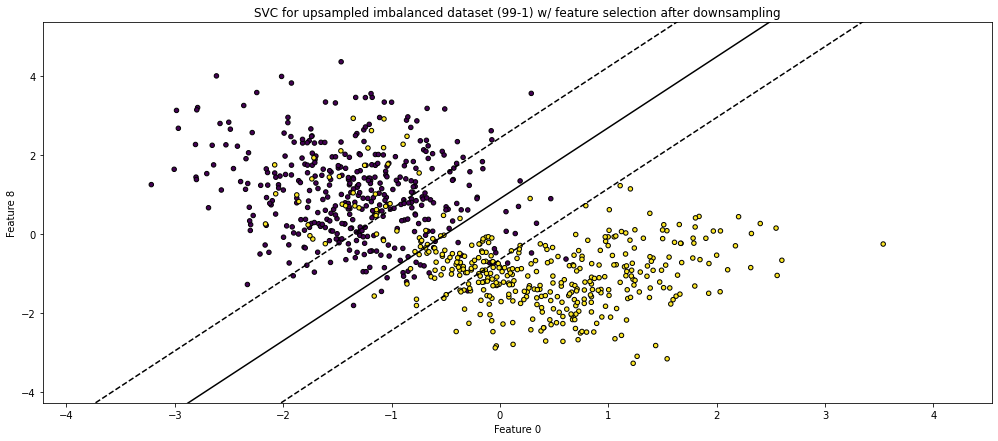

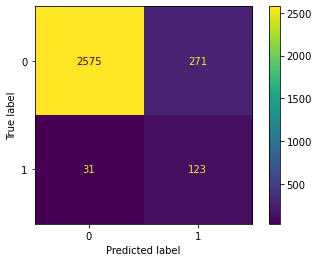

In [11]:
accuracies_per_dataset_per_balance = []
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(17)
ax.set(xlabel="Feature 0", ylabel="Feature 8")
ax.title.set_text("SVC for upsampled imbalanced dataset (99-1) w/ feature selection after downsampling")
imbalances = [99, 95, 85, 75, 50]

for idx1, (training_datasets, test_datasets) in enumerate(zip(training_datasets_per_balance, testing_datasets_per_balance)):
    accuracies_per_dataset_per_balance += [[]]
    for idx2, (sampled_training_datasets, sampled_test_datasets) in enumerate(zip(training_datasets, test_datasets)): 
        accuracies_per_dataset_per_balance[idx1] += [[]]
        for idx3, ((training_data_x, training_data_y), (test_data_x, test_data_y)) in enumerate(zip(sampled_training_datasets, sampled_test_datasets)):
            accuracies_per_dataset_per_balance[idx1][idx2] += [[]]
            if training_data_x.empty:
                accuracies_per_dataset_per_balance[idx1][idx2][idx3] += [0]
                continue
            svc_model = svm.SVC(kernel='linear')
            svc_model = svc_model.fit(training_data_x, training_data_y)
            synthetic_data_y_pred = svc_model.predict(test_data_x)
            accuracy = metrics.accuracy_score(test_data_y, synthetic_data_y_pred, sample_weight=list(map(lambda x: (imbalances[idx1]/(100-imbalances[idx1]))*x+1, np.array(test_data_y))))
            matrix = confusion_matrix(test_data_y, synthetic_data_y_pred)   
            if idx1 == 1 and idx2 == 0 and idx3 == 1:
                X0, X1 = training_data_x[0], training_data_x[8]
                w = svc_model.coef_[0]
                a = -w[0] / w[1]
                xx = np.linspace(-5, 5)
                yy = a * xx - (svc_model.intercept_[0]) / w[1]
                x_min, x_max = X0.min() - 1, X0.max() + 1
                y_min, y_max = X1.min() - 1, X1.max() + 1
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)
                margin = 1 / np.sqrt(np.sum(svc_model.coef_**2))
                yy_down = yy - np.sqrt(1 + a**2) * margin
                yy_up = yy + np.sqrt(1 + a**2) * margin
                ax.scatter(X0, X1, c=training_data_y, s=20, edgecolors='k')
                ax.plot(xx, yy, "k-")
                ax.plot(xx, yy_down, "k--")
                ax.plot(xx, yy_up, "k--")
                cmd = ConfusionMatrixDisplay(matrix, display_labels=np.unique(test_data_y)).plot()
                 
            accuracies_per_dataset_per_balance[idx1][idx2][idx3] += [accuracy]

Now that we have access to the accuracy of each model, we may visualize these accuracies. Each plot represents the accuracies for a sampled dataset. The first accuracy (blue) represents the accuracy of the model with no feature selection on the dataset, the second and third accuracies (red and green) represent the accuracies of the models with feature selection using Pearson's correlations respectively before and after the dataset was upsampled/downsampled. We are particularly interested in comparing these last two accuracies since they will conclude which set of selected features is best.

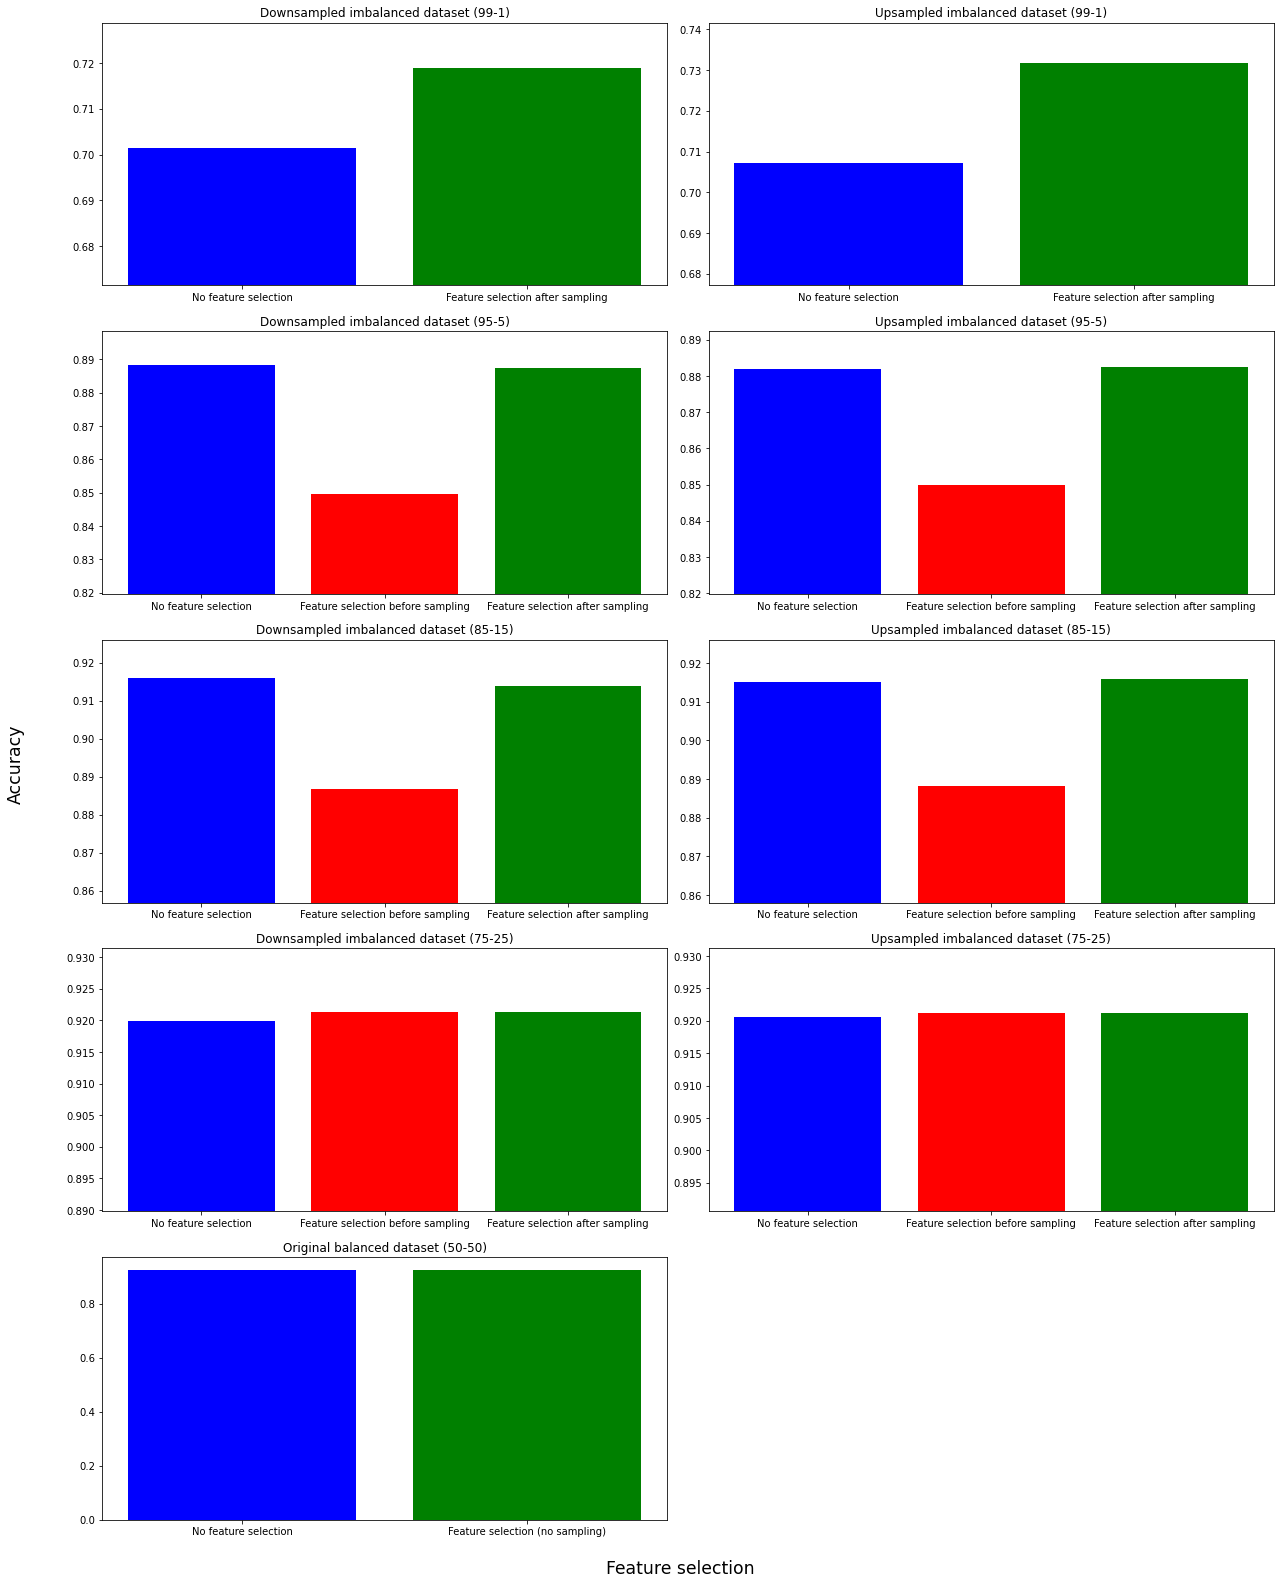

In [12]:
titles = [["Downsampled imbalanced dataset (99-1)", "Upsampled imbalanced dataset (99-1)"],
          ["Downsampled imbalanced dataset (95-5)", "Upsampled imbalanced dataset (95-5)"],
          ["Downsampled imbalanced dataset (85-15)", "Upsampled imbalanced dataset (85-15)"],
          ["Downsampled imbalanced dataset (75-25)", "Upsampled imbalanced dataset (75-25)"],
          ["Original balanced dataset (50-50)"]]

legend = ["No feature selection",
          "Feature selection before sampling",
          "Feature selection after sampling"]

fig, axs = plt.subplots(5, 2)
fig.set_figheight(15)
fig.set_figwidth(17)
fig.tight_layout()
fig.delaxes(axs[4][1])
fig.text(0.5, -0.45, 'Feature selection', ha='center', fontsize='xx-large')
fig.text(-0.05, 0.30, 'Accuracy', va='center', rotation='vertical', fontsize='xx-large')
fig.subplots_adjust(bottom=-0.4)

for idx1, accuracies_per_dataset in enumerate(accuracies_per_dataset_per_balance[:-1]):
    for idx2, accuracies_per_sampled_dataset in enumerate(accuracies_per_dataset):
        names = []
        accuracies = []
        colors = []
        for idx3, accuracy_per_dataset in enumerate(accuracies_per_sampled_dataset):
            accuracy = accuracy_per_dataset[0]
            if not accuracy == 0:
                if idx3 == 0:
                    colors += ["Blue"]
                elif idx3 == 1:
                    colors += ["Red"]    
                else:
                    colors += ["Green"]
                names = names + [legend[idx3]]
                accuracies = accuracies + [accuracy]
        axs[idx1][idx2].bar(names, accuracies, color=colors)
        axs[idx1][idx2].title.set_text(titles[idx1][idx2])
        axs[idx1][idx2].set_ylim(min(accuracies)-0.03, max(accuracies)+0.01)

axs[4][0].bar(["No feature selection", "Feature selection (no sampling)"], accuracies_per_dataset_per_balance[4][0][-1], color=["Blue", "Green"])
axs[4][0].title.set_text(titles[4][0])

As can be seen in the plots above, the greater the imbalance of the initial dataset, the greater the difference between the accuracies of models trained on data with feature selection before and after sampling. This is due to significant features not being selected by the Pearson's correlations on the imbalanced data since their absolute value shrinks to the point where they do not meet the defined threshold (0.3 in our case). In the case of extremely imbalanced dataset (99-1), the absolute values of the Pearson's correlations for the significant features were so low that no features were selected. In contrary, feature selection performed on dataset with a moderate case of imbalance (75-25) already managed to select all the significant features. 

The training sets are now used again to train *K-Nearest Neighbors Classifier* models. An increasing number of neighbors ranging from 1 to 100 is tried for each training set. 

In [13]:
accuracies_per_dataset_per_balance = []
neighbors = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for idx1, (training_datasets, test_datasets) in enumerate(zip(training_datasets_per_balance, testing_datasets_per_balance)):
    accuracies_per_dataset_per_balance += [[]]
    for idx2, (sampled_training_datasets, sampled_test_datasets) in enumerate(zip(training_datasets, test_datasets)): 
        accuracies_per_dataset_per_balance[idx1] += [[]]
        for idx3, ((training_data_x, training_data_y), (test_data_x, test_data_y)) in enumerate(zip(sampled_training_datasets, sampled_test_datasets)):
            accuracies_per_dataset_per_balance[idx1][idx2] += [[]]
            for neighbour in neighbors:
                if training_data_x.empty:
                    accuracies_per_dataset_per_balance[idx1][idx2][idx3] += [0]
                else:
                    knn_model = KNeighborsClassifier(neighbour, weights="uniform", n_jobs=-1)
                    knn_model.fit(training_data_x, training_data_y)
                    synthetic_data_y_pred = knn_model.predict(test_data_x)
                    accuracy = metrics.accuracy_score(test_data_y, synthetic_data_y_pred, sample_weight=list(map(lambda x: (imbalances[idx1]/(100-imbalances[idx1]))*x+1, np.array(test_data_y))))
                    accuracies_per_dataset_per_balance[idx1][idx2][idx3] += [accuracy]

The accuracies for each model across the increasing number of neighbors are plotted below. If we were to want to draw the same conclusion as we did in the case of SVC's, the average accuracy for the model trained on the training set on which feature extraction was performed based on the Pearson's correlations of the sampled dataset, should be higher than the average accuracy of the model trained on the training set on which feature extraction before the sampling.

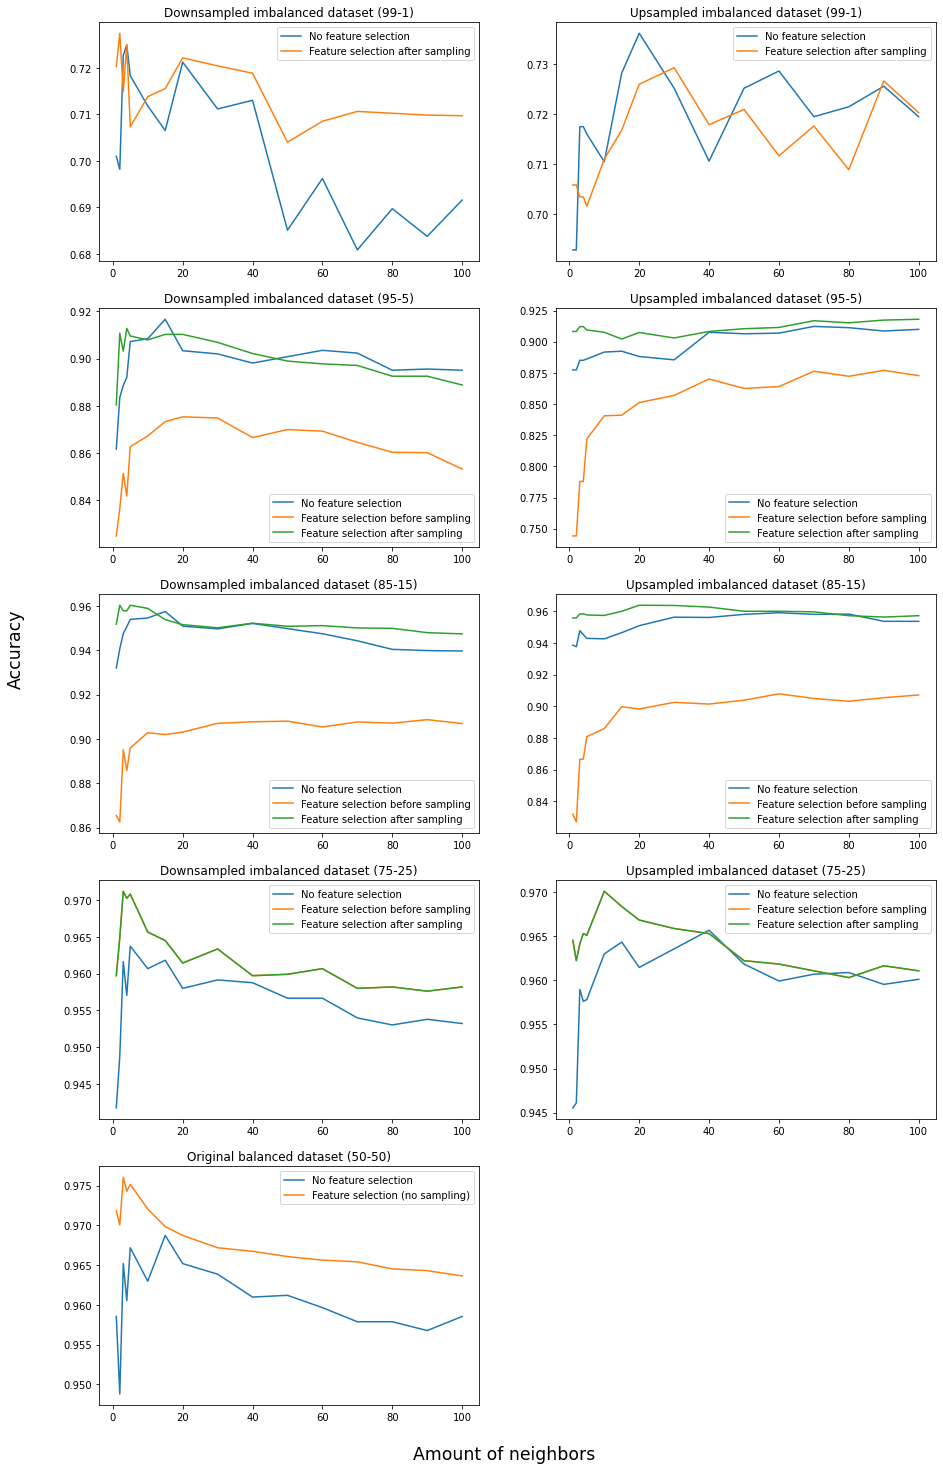

In [14]:
fig, axs = plt.subplots(5, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.delaxes(axs[4][1])
fig.text(0.5, -0.45, 'Amount of neighbors', ha='center', fontsize='xx-large')
fig.text(0.04, 0.30, 'Accuracy', va='center', rotation='vertical', fontsize='xx-large')
fig.subplots_adjust(bottom=-0.4)

for idx1, accuracies_per_dataset in enumerate(accuracies_per_dataset_per_balance[:-1]):
    for idx2, accuracies_per_sampled_dataset in enumerate(accuracies_per_dataset):
        for idx3, accuracies_per_dataset in enumerate(accuracies_per_sampled_dataset):
            if not all(v == 0 for v in accuracies_per_dataset):
                axs[idx1][idx2].plot(neighbors, accuracies_per_dataset, label=legend[idx3])
        axs[idx1][idx2].title.set_text(titles[idx1][idx2])
        axs[idx1][idx2].legend()

axs[4][0].plot(neighbors, accuracies_per_dataset_per_balance[4][0][0], label=legend[0])
axs[4][0].plot(neighbors, accuracies_per_dataset_per_balance[4][0][1], label="Feature selection (no sampling)")
axs[4][0].title.set_text(titles[4][0])
axs[4][0].legend()

We may once again notice the same trends that were present when using SVC models. The accuracies across the increasing number of neighbors are clearly significantly lower for the model that was trained on the training set with features selected from the original imbalanced dataset compared to the accuracies of the model trained on the training set with features selected from the sampled dataset. 

### Conclusions

When using feature selection, based on the Pearson's correlations, on imbalanced datasets, we should be careful not to discard any significant features as the absolute value of their Pearson's correlation decreases with respect to the imbalance of the dataset. We may either use a lower threshold to tackle this issue, or preferably balance our dataset first before performing feature selection such that the significant features are more apparent.

### Real-life dataset

Our experimental setup will now be repeated on a real-life dataset. If our previously drawn conclusions hold, the feature selection using Pearson's correlations should be performed after the dataset in sampled in order to approach optimal results. 

The dataset that we will be using holds information that concerns whether or not a person would be interested in a vehicle insurance based on 11 features. The class imbalance of the dataset is visualized below (+- 84-16).

Imbalance ratio: 0.16448


<BarContainer object of 2 artists>

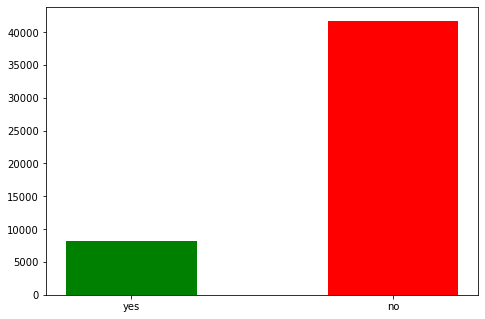

In [15]:
# Imbalanced dataset from Kaggle
# od.download("https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice?select=aug_train.csv")
kaggle_data = pd.read_csv(r'imbalanced-data-practice/aug_train.csv')
kaggle_data= kaggle_data[0:50000] # Orignal size > 300.000

# Show Class Imbalance
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
imbalance = [kaggle_data[kaggle_data['Response']==1].count()["Response"],
             kaggle_data[kaggle_data['Response']==0].count()["Response"]]
print("Imbalance ratio: " + str(imbalance[0]/50000))
classes = ['yes', 'no']
ax.bar(classes, imbalance, width=0.5, color=["Green", "Red"])

Some code to transform categorical features into numeric ones. We also scale our data to enhance the final accuracies.

In [16]:
# Transform categorical data into numerical data
# Binary features
kaggle_data['Gender']= LabelEncoder().fit_transform(kaggle_data['Gender'])
kaggle_data['Vehicle_Damage']= LabelEncoder().fit_transform(kaggle_data['Vehicle_Damage'])

# 3 categories with degree of order 
kaggle_data['Vehicle_Age'] = kaggle_data['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})

# Scale data
kaggle_x = kaggle_data.copy()
kaggle_x.pop("Response")
kaggle_y = kaggle_data['Response']

scaler_sd = StandardScaler()
scaler_sd.fit(kaggle_x)
scaled_kaggle_x = scaler_sd.transform(kaggle_x)
kaggle_x = pd.DataFrame(scaled_kaggle_x, columns=kaggle_x.columns)
kaggle_data_x_train, kaggle_data_x_test, kaggle_data_y_train, kaggle_data_y_test = train_test_split(kaggle_x, kaggle_y, test_size=0.3,random_state=44)
        
kaggle_data = kaggle_data_x_train
kaggle_data['Response'] = kaggle_data_y_train

print(kaggle_data[0:5])

             id    Gender       Age  Driving_License  Region_Code  \
25141  0.380975 -1.086750  2.446716         0.044541     1.112524   
28110  1.224833  0.920175 -0.759874         0.044541     0.129160   
37293 -0.206304 -1.086750 -1.021637         0.044541     0.809950   
2035   0.561811  0.920175 -1.087077         0.044541     0.961237   
12637 -0.144881  0.920175  2.446716         0.044541    -1.308065   

       Previously_Insured  Vehicle_Age  Vehicle_Damage  Annual_Premium  \
25141           -0.979569     0.691234        1.039291        0.760222   
28110            1.020857    -1.072208       -0.962194       -0.473764   
37293           -0.979569    -1.072208        1.039291        0.085676   
2035             1.020857    -1.072208       -0.962194        0.579667   
12637           -0.979569     0.691234        1.039291        1.345015   

       Policy_Sales_Channel   Vintage  Response  
25141             -1.838545 -1.653528         0  
28110              0.741136  1.202940   

Create the upsampled and downsampled datasets

In [17]:
# Separate majority and minority classes
majority = kaggle_data[kaggle_data["Response"]==0]
minority = kaggle_data[kaggle_data["Response"]==1]

min_amount = len(minority)
# Downsample majority class
majority_downsampled = resample(majority, replace=False, n_samples=min_amount, random_state=123) 
# Upsample minority class
maj_amount = len(majority)
minority_upsampled = resample(minority, replace=True, n_samples=maj_amount, random_state=123)
     
# Combine minority class with downsampled majority class
downsampled = pd.concat([majority_downsampled, minority])
upsampled = pd.concat([minority_upsampled, majority])
kaggle_data_upsampled = upsampled
kaggle_data_downsampled = downsampled

In the correlation matrices below, we may once again notice that the absolute values for the correlations of significant features are lower in the case of class imbalance.

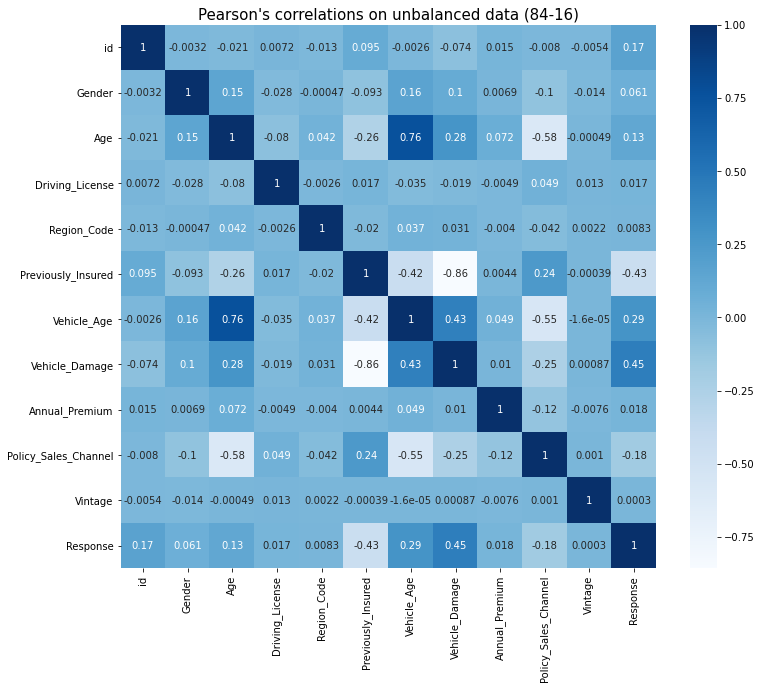

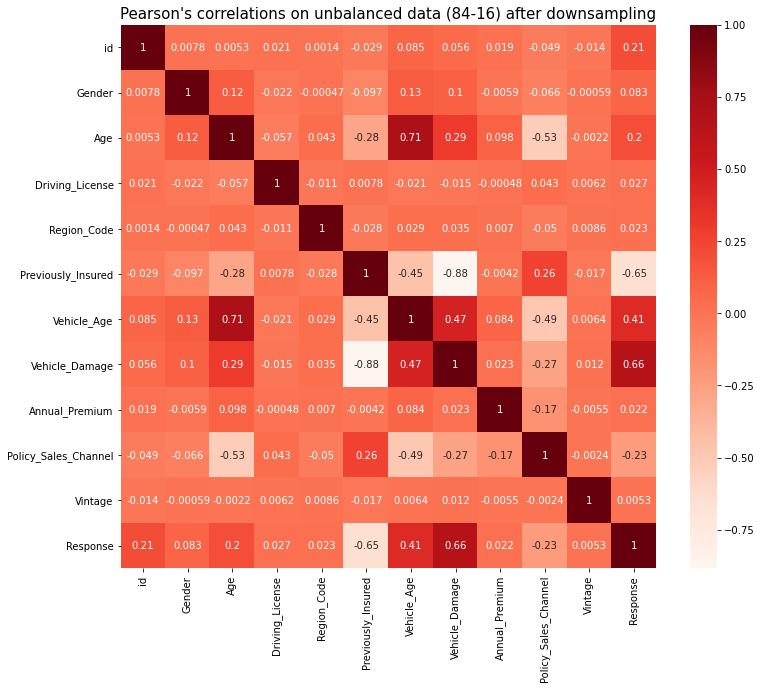

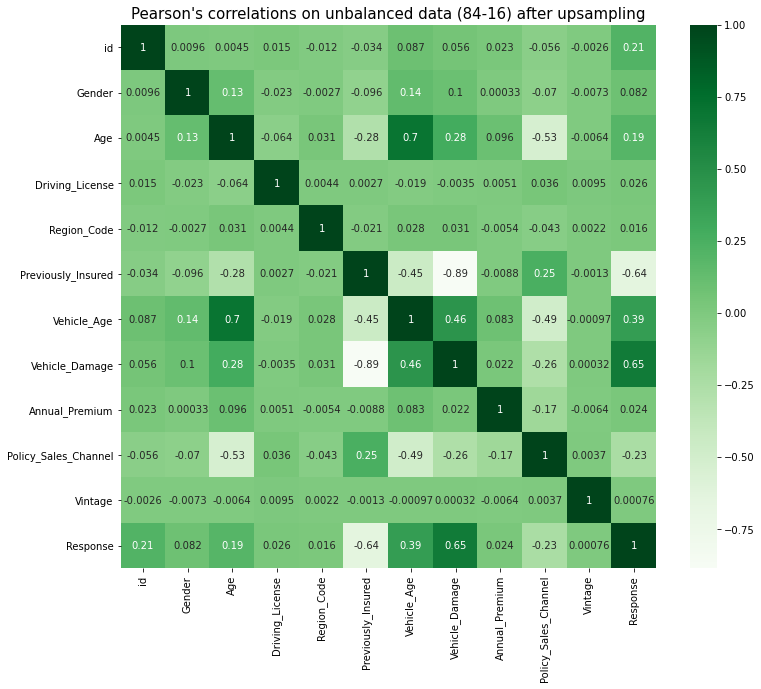

In [18]:
kaggle_datasets = [kaggle_data, kaggle_data_downsampled, kaggle_data_upsampled]
titles = ["Pearson's correlations on unbalanced data (84-16)",
         "Pearson's correlations on unbalanced data (84-16) after downsampling",
         "Pearson's correlations on unbalanced data (84-16) after upsampling"]
colors = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
correlations = []

for ctr, dataset in enumerate(kaggle_datasets):
    plt.figure(figsize=(12,10))
    plt.title(titles[ctr], fontsize=15)
    correlations = correlations + [dataset.corr()]
    sns.heatmap(correlations[ctr], annot=True, cmap=colors[ctr])
    plt.show()

This time we use a threshold of 0.2, as we can see the features *id* and *Policy_Sales_Channel* are not selected when looking at the Pearson's correlations based the imbalanced dataset.    

In [19]:
relevant_features = []

for ctr, corr in enumerate(correlations):
    print(titles[ctr])
    target = abs(corr["Response"])
    features = target[target>0.2]
    print(features)
    print("---------------------------")
    relevant_features = relevant_features + [features]

Pearson's correlations on unbalanced data (84-16)
Previously_Insured    0.432847
Vehicle_Age           0.287602
Vehicle_Damage        0.447586
Response              1.000000
Name: Response, dtype: float64
---------------------------
Pearson's correlations on unbalanced data (84-16) after downsampling
id                      0.210436
Age                     0.203487
Previously_Insured      0.647563
Vehicle_Age             0.407446
Vehicle_Damage          0.659591
Policy_Sales_Channel    0.232343
Response                1.000000
Name: Response, dtype: float64
---------------------------
Pearson's correlations on unbalanced data (84-16) after upsampling
id                      0.214150
Previously_Insured      0.643071
Vehicle_Age             0.392406
Vehicle_Damage          0.651217
Policy_Sales_Channel    0.231809
Response                1.000000
Name: Response, dtype: float64
---------------------------


Generate training and test sets given selected features.

In [20]:
sampled_training_datasets = []
testing_datasets_per_sample = []

for idx1, kaggle_dataset in enumerate(kaggle_datasets[1:]):
    sampled_training_datasets += [[]]
    testing_datasets_per_sample += [[]]
    for i in range(0, 3):
        kaggle_data_x = kaggle_data.copy()
        kaggle_data_x.pop("Response")
        kaggle_data_y = kaggle_data['Response']
        data_x_test = kaggle_data_x_test

        if i == 1:
            features = list(map(lambda x: kaggle_data_x.columns.get_loc(x),
                          relevant_features[0].keys()[:-1].values.tolist()))
            kaggle_data_x = kaggle_data_x.iloc[:, features]
            data_x_test = data_x_test.iloc[:, features]
        if i == 2:
            features = list(map(lambda x: kaggle_data_x.columns.get_loc(x),
                          relevant_features[idx1+1].keys()[:-1].values.tolist()))
            kaggle_data_x = kaggle_data_x.iloc[:, features]
            data_x_test = data_x_test.iloc[:, features]

        sampled_training_datasets[idx1] += [(kaggle_data_x, kaggle_data_y)]
        testing_datasets_per_sample[idx1] += [(data_x_test, kaggle_data_y_test)]

Repetition of the SVC experiment

In [21]:
accuracies_per_sampled_dataset = []

for idx1, (training_datasets, testing_datasets) in enumerate(zip(sampled_training_datasets, testing_datasets_per_sample)):
    accuracies_per_sampled_dataset += [[]]
    for idx2, ((training_data_x, training_data_y), (testing_data_x, testing_data_y)) in enumerate(zip(training_datasets, testing_datasets)):
        accuracies_per_sampled_dataset[idx1] += [[]]
        svc_model = svm.SVC(kernel='linear')
        svc_model = svc_model.fit(training_data_x, training_data_y)
        kaggle_data_y_pred = svc_model.predict(testing_data_x)
        accuracy = metrics.accuracy_score(testing_data_y, kaggle_data_y_pred, sample_weight=list(map(lambda x: (84/16)*x+1, np.array(testing_data_y))))
        accuracies_per_sampled_dataset[idx1][idx2] += [accuracy]

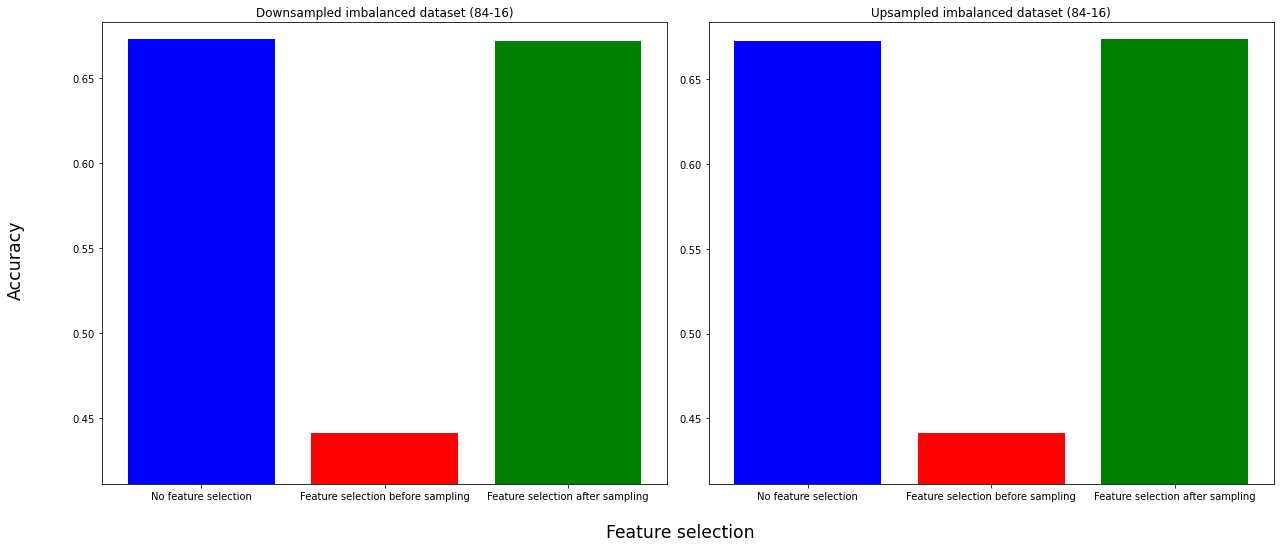

In [22]:
titles = ["Downsampled imbalanced dataset (84-16)", "Upsampled imbalanced dataset (84-16)"]

legend = ["No feature selection",
          "Feature selection before sampling",
          "Feature selection after sampling"]

fig, axs = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(17)
fig.tight_layout()
fig.text(0.5, -0.05, 'Feature selection', ha='center', fontsize='xx-large')
fig.text(-0.05, 0.50, 'Accuracy', va='center', rotation='vertical', fontsize='xx-large')

for idx1, accuracies_per_dataset in enumerate(accuracies_per_sampled_dataset):
    colors = []
    names = []
    accuracies = []
    for idx2, accuracy_per_dataset in enumerate(accuracies_per_dataset):
        accuracy = accuracy_per_dataset[0]
        if idx2 == 0:
            colors += ["Blue"]
        elif idx2 == 1:
            colors += ["Red"]    
        else:
            colors += ["Green"]
        names += [legend[idx2]]
        accuracies += [accuracy]
    axs[idx1].bar(names, accuracies, color=colors)
    axs[idx1].title.set_text(titles[idx1])
    axs[idx1].set_ylim(min(accuracies)-0.03, max(accuracies)+0.01)

As expected, we once again witness the same trends we did when using synthetic data but the gap in accuracy between both timings of feature selection is even bigger this time around.

Repetition of the KNN experiment

In [23]:
accuracies_per_sampled_dataset = []
neighbors = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for idx1, (training_datasets, testing_datasets) in enumerate(zip(sampled_training_datasets, testing_datasets_per_sample)):
    accuracies_per_sampled_dataset += [[]]
    for idx2, ((training_data_x, training_data_y), (testing_data_x, testing_data_y)) in enumerate(zip(training_datasets, testing_datasets)):
        accuracies_per_sampled_dataset[idx1] += [[]]
        for neighbour in neighbors:
            knn_model = KNeighborsClassifier(neighbour, weights="uniform", n_jobs=-1)
            knn_model.fit(training_data_x, training_data_y)
            kaggle_data_y_pred = knn_model.predict(testing_data_x)
            accuracy = metrics.accuracy_score(testing_data_y, kaggle_data_y_pred, sample_weight=list(map(lambda x: (84/16)*x+1, np.array(testing_data_y))))
            accuracies_per_sampled_dataset[idx1][idx2] += [accuracy]

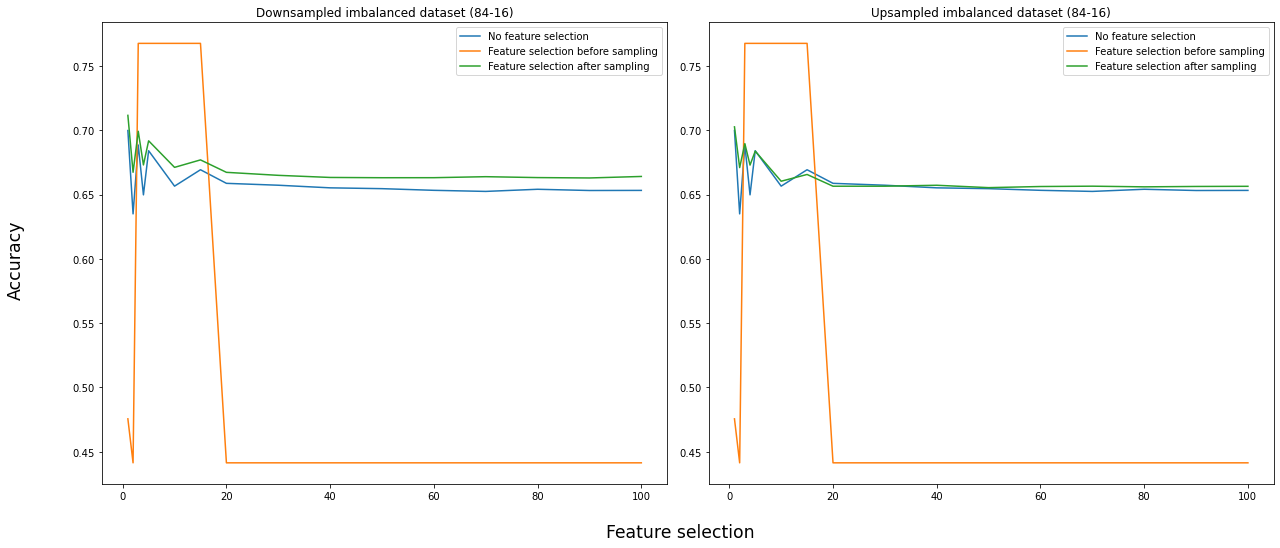

In [24]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(17)
fig.tight_layout()
fig.text(0.5, -0.05, 'Feature selection', ha='center', fontsize='xx-large')
fig.text(-0.05, 0.50, 'Accuracy', va='center', rotation='vertical', fontsize='xx-large')

for idx1, accuracies_per_dataset in enumerate(accuracies_per_sampled_dataset):
    for idx2, accuracies in enumerate(accuracies_per_dataset):
        axs[idx1].plot(neighbors, accuracies, label=legend[idx2])
    axs[idx1].title.set_text(titles[idx1])
    axs[idx1].legend()

As expected, we once again witness the same trends we did when using synthetic data. Concluding that the performing the feature selection on the imbalanced dataset resulted in a loss of significant features.

## Research Question 2
The second question we aim to answer in this notebook, is how the distribution of input-variables of datapoints affects a regression algorithm's ability to fit the data. This is an interesting thing to investigate because real data is not always uniformly distributed. For example a people's heights tend to be normally distributed. In this section, we will fit multiple regression algorithms to several synthetic datasets that had their datapoints generated from different types of distributions. We will be working with only 1 input dimension since this makes it easier for us to plot the data.

In [25]:
### Some functions to help us visualise ###
def plot_function(function, range=(0, 1), ax=plt):
    line = ax.plot(np.linspace(range[0], range[1], 100), function(np.linspace(range[0], range[1], 100)))
    return ax, line[0]

def plot_data(x, y, ax=plt):
    line = ax.scatter(x, y)
    return ax, line

def plot_data_cdf(x, ax=plt):
    sorted = np.sort(x)
    p = np.arange(len(x)) / (len(x) - 1)
    line = ax.plot(sorted, p)
    return ax, line[0]

def plot_distr_cdf(distr, range=(0, 1), ax=plt):
    return plot_function(distr.cdf, range, ax)

def plot_distr_pdf(distr, range=(0, 1), ax=plt):
    return plot_function(distr.pdf, range, ax)

def plot_distrs(x, distr, range=(0, 1), ax=plt):
    _, line = plot_data_cdf(x, ax)
    line.set_label("Data CDF")
    _, line = plot_distr_cdf(distr, range=range, ax=ax)
    line.set_label("Distribution CDF")
    ax.legend()
    return ax

def minmax(x):
    return (min(x), max(x))

def multiply_fig_size(fig, row, col):
    size = np.array(fig.get_size_inches()) * np.array([col, row])
    fig.set_size_inches(size)
    return fig


We will test the algorithms on various distributions of input data. The distributions we will be using are a uniform distribution (as a baseline), a normal distribution and an exponential distribution. We shift, scale and truncate the distributions to be in the range [0, 1]. The range in which the generated points fall, which is decided by the distribution, influences which part of the target function the algorithm will try to fit. By bringing each of these distributions to the same range, we ensure a fair comparison. The distributions are scaled by a factor 0.2, at which point around 99% of the values for the non-truncated version will fall in the range [0, 1].

To visualise how these distributions generate their datapoints, we plot the probability density and cummulative density functions for each of them in the cell below. I also include graphs visualising the similarity between the distributions and their truncated version in the interval [0, 1].

A normal distribution with mean 0.5 and std 0.2 has 99% of its values in the range [-0.01516586070978021, 1.01516586070978]
A exponential distribution with scale 0.2 has 99% of its values in range [0, 0.9210340371976182]


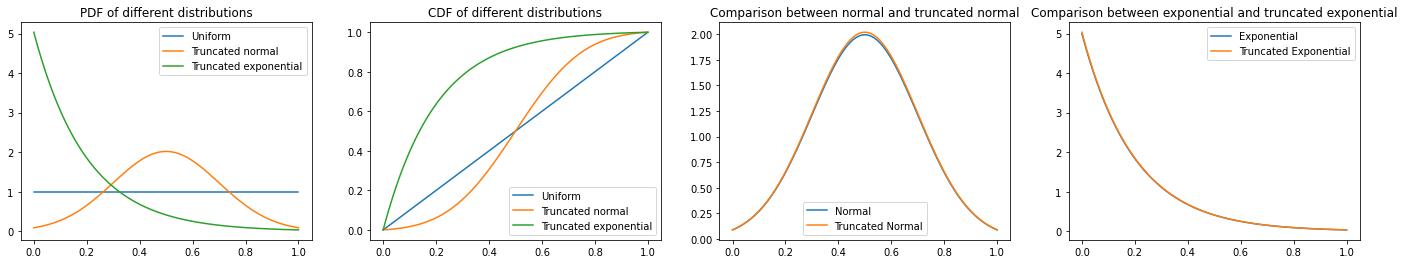

In [26]:
# Uniform distribution
def uniform():
    return stats.uniform()

# Truncated normal distribution
def trunc_norm(mean=0.5, std=0.2):
    a, b, mu, sig = 0, 1, mean, std
    ### --- Code adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html#notes
    a, b = (a - mu) / sig, (b - mu) / sig
    ### --- It updates the boundaries of the normal distribution based on the mean and std
    xdistr = stats.truncnorm(a, b, loc=mu, scale=sig)
    return xdistr

# Truncated exponential
def trunc_expon(scale=0.2):
    return stats.truncexpon(1/scale, loc=0, scale=scale)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
multiply_fig_size(fig, 1, 4)

# Visualise uniform distribution
uniform_distr = uniform()
_, line = plot_distr_pdf(uniform_distr, ax=ax1)
line.set_label("Uniform")
_, line = plot_distr_cdf(uniform_distr, ax=ax2)
line.set_label("Uniform")

# Visualise truncated normal distribution
mean, std = 0.5, 0.2
trunc_norm_distr = trunc_norm(mean, std)
uniform_distr = uniform()
_, line = plot_distr_pdf(trunc_norm_distr, ax=ax1)
line.set_label("Truncated normal")
_, line = plot_distr_cdf(trunc_norm_distr, ax=ax2)
line.set_label("Truncated normal")

normal_distr = stats.norm(loc=mean, scale=std)
print(f"A normal distribution with mean {mean} and std {std} has 99% of its values in the range [{normal_distr.ppf(0.005)}, {normal_distr.ppf(0.995)}]")

# Plot difference between normal and truncated_normal
plot_distr_pdf(normal_distr, ax=ax3)[1].set_label("Normal")
plot_distr_pdf(trunc_norm_distr, ax=ax3)[1].set_label("Truncated Normal")
ax3.set_title("Comparison between normal and truncated normal")
ax3.legend()

# Visualise truncated exponential distribution
scale = 0.20
trunc_expon_distr = trunc_expon(scale)
_, line = plot_distr_pdf(trunc_expon_distr, ax=ax1)
line.set_label("Truncated exponential")
_, line = plot_distr_cdf(trunc_expon_distr, ax=ax2)
line.set_label("Truncated exponential")

expon_distr = stats.expon(scale=scale)
print(f"A exponential distribution with scale {scale} has 99% of its values in range [0, {expon_distr.ppf(0.99)}]")

# Plot difference between exponential and exponential
plot_distr_pdf(expon_distr, ax=ax4)[1].set_label("Exponential")
plot_distr_pdf(trunc_expon_distr, ax=ax4)[1].set_label("Truncated Exponential")
ax4.set_title("Comparison between exponential and truncated exponential")
ax4.legend()


distrs = [uniform_distr, trunc_norm_distr, trunc_expon_distr]
distr_names = ["uniform", "truncated normal", "truncated exponential"]

ax1.set_title("PDF of different distributions")
ax2.set_title("CDF of different distributions")
ax1.legend()
ax2.legend()


### Algorithms
We'll attempt to fit the target functions using different regression algorithms.
The first algorithms we'll use is the Kernel Ridge Regression algorithm. As the name suggests this is a Ridge Regression algorithm that uses the kernel trick to transform data to a (higher dimension) feature space. The Ridge Regression algorithm fits the data


#### SVR
The first algorithm we'll be using is the support vector regressor (SVR). It is an extension to the support vector classifier (SVM) algorithm. 

Let $D = \{d_i | 1 \leq i \leq N\}$ be our training samples and $y = \{y_i | 1 \leq i \leq N\}$ their target values. The SVR learns a hypothesis

$$ f(x) = \sum_{i=1}^N(\alpha_i^{*} - \alpha_i)*(d_ix + 1)^p + b $$

Where the values for $\alpha_i, \alpha_i^{*}$ and $b$ are learned during training. The SVR searches the hypothesis space for the optimal values for these parameters. Optimal values for these parameters are those that minimise the following objective function:

$$ C\sum_{i=1}^NL_\epsilon(y_i - F(d_i, w)) + ||w||^2 $$

The objective is a sum of 2 terms. The first being the $\epsilon$-insensitive loss between the prediction and target value. The second term is the regularisation term. The amount of regularisation can be controller by changing the value of the parameter $C$.

The $\epsilon$-insensitive loss function $L_\epsilon$ used in the objective function is defined as follows
$$ 
L_\epsilon(x) = \left\{
    \begin{array}{ll}
        0 & if |x| < \epsilon \\
        |x| - \epsilon & if |x| \geq \epsilon
    \end{array}
\right.
$$
In the case of our objective function, the loss will be zero if the error ($|y_i - F(d_i, w)|$) is smaller than $\epsilon$, otherwise the loss will be how much the error exceeds this limit.This can be interpreted as creating an $\epsilon$-wide boundary around $F$. Any point $(d_i, y_i)$ which lies in this boundary will not contribute to the objective function, and its corresponding $\alpha_i^{*}$ and $\alpha_i$ will be zero. Otherwise, atleast one of two will be non-zero, and we call $d_i$ a support vector.

The objective function we are minimising can be rewritten as:
$$ C\sum_{i=1}^N(\xi_i + \xi_i^*) + ||w||^2 $$
Where $\xi_i$ and $\xi_i^*$ are how far the datapoint $d_i$ lies above or below the $\epsilon$ wide boundary. We minimise this objective function subject to the following conditions:
$$
y_i-(w^td_i)-b \leq \epsilon+\xi_i \\
(w^td_i)+b-y_i \leq \epsilon+\xi_i^* \\
\xi_i^* \geq 0 \\
\xi_i \geq 0
$$
The first two conditions specify that $(d_i, y_i)$ should be within $\xi_i^{(*)}$ of the $\epsilon$-boundary. The last two constrain this distances to be positive or zero. Solving the langrangian of this constrained problem will give us the optimal values for $\alpha_i, \alpha_i^{*}$ and $b$.

We can definitely see the similarities between this and the soft-margin SVM. In the soft-margin SVM, we have a margin that we want points to lie outside, and penalise the objective functions for any points that lie inside the margin. With SVR we do the opposite, we have a margin ($\epsilon$-wide boundary) that we want points to lie inside, and panalise the objective functions for any points that lie outside of it.

Finally, we can extend this algorithm to higher dimensional feature spaces using the kernel trick.

*(source: https://proceedings.neurips.cc/paper/1996/file/d38901788c533e8286cb6400b40b386d-Paper.pdf)*

#### KNN
A K-Nearest-Neighbour (KNN) algorithm predicts the value for a point based on the points it is close to, its neighbours. Specifically, these algorithms provide the user with a tunable hyperparameter $k$ which determines how many of these neighbours we want to take into account.

A KNN classifier classifies a point as the majority label among its $k$ neighbours. Let $\{d_i | 1 \leq i \leq k\}$ be the $k$ training samples nearest to $x$ and $y = \{y_i | 1 \leq i \leq k\}$ their classifications.
$$  
    F(x) = sign(\sum_{i=1}^k y_i)
$$
Turning this into a regressor is simple. Instead of taking the sign of the sum of the output of our neighbours, we take the mean. Let $\{d_i | 1 \leq i \leq k\}$ be the $k$ training samples nearest to $x$ and $y = \{y_i | 1 \leq i \leq k\}$ their values.
$$  
    F(x) = \frac{\sum_{i=1}^k y_i}{k}
$$

*(source: )*

In [27]:
### Algorithms
We'll attempt to fit the target functions using different regression algorithms.
The first algorithms we'll use is the Kernel Ridge Regression algorithm. As the name suggests this is a Ridge Regression algorithm that uses the kernel trick to transform data to a (higher dimension) feature space. The Ridge Regression algorithm fits the data


#### SVR
The first algorithm we'll be using is the support vector regressor (SVR). It is an extension to the support vector classifier (SVM) algorithm. 

Let $D = \{d_i | 1 \leq i \leq N\}$ be our training samples and $y = \{y_i | 1 \leq i \leq N\}$ their target values. The SVR learns a hypothesis

$$ f(x) = \sum_{i=1}^N(\alpha_i^{*} - \alpha_i)*(d_ix + 1)^p + b $$

Where the values for $\alpha_i, \alpha_i^{*}$ and $b$ are learned during training. The SVR searches the hypothesis space for the optimal values for these parameters. Optimal values for these parameters are those that minimise the following objective function:

$$ C\sum_{i=1}^NL_\epsilon(y_i - F(d_i, w)) + ||w||^2 $$

The objective is a sum of 2 terms. The first being the $\epsilon$-insensitive loss between the prediction and target value. The second term is the regularisation term. The amount of regularisation can be controller by changing the value of the parameter $C$.

The $\epsilon$-insensitive loss function $L_\epsilon$ used in the objective function is defined as follows
$$ 
L_\epsilon(x) = \left\{
    \begin{array}{ll}
        0 & if |x| < \epsilon \\
        |x| - \epsilon & if |x| \geq \epsilon
    \end{array}
\right.
$$
In the case of our objective function, the loss will be zero if the error ($|y_i - F(d_i, w)|$) is smaller than $\epsilon$, otherwise the loss will be how much the error exceeds this limit.This can be interpreted as creating an $\epsilon$-wide boundary around $F$. Any point $(d_i, y_i)$ which lies in this boundary will not contribute to the objective function, and its corresponding $\alpha_i^{*}$ and $\alpha_i$ will be zero. Otherwise, atleast one of two will be non-zero, and we call $d_i$ a support vector.

The objective function we are minimising can be rewritten as:
$$ C\sum_{i=1}^N(\xi_i + \xi_i^*) + ||w||^2 $$
Where $\xi_i$ and $\xi_i^*$ are how far the datapoint $d_i$ lies above or below the $\epsilon$ wide boundary. We minimise this objective function subject to the following conditions:
$$
y_i-(w^td_i)-b \leq \epsilon+\xi_i \\
(w^td_i)+b-y_i \leq \epsilon+\xi_i^* \\
\xi_i^* \geq 0 \\
\xi_i \geq 0
$$
The first two conditions specify that $(d_i, y_i)$ should be within $\xi_i^{(*)}$ of the $\epsilon$-boundary. The last two constrain this distances to be positive or zero. Solving the langrangian of this constrained problem will give us the optimal values for $\alpha_i, \alpha_i^{*}$ and $b$.

We can definitely see the similarities between this and the soft-margin SVM. In the soft-margin SVM, we have a margin that we want points to lie outside, and penalise the objective functions for any points that lie inside the margin. With SVR we do the opposite, we have a margin ($\epsilon$-wide boundary) that we want points to lie inside, and panalise the objective functions for any points that lie outside of it.

Finally, we can extend this algorithm to higher dimensional feature spaces using the kernel trick.

*(source: https://proceedings.neurips.cc/paper/1996/file/d38901788c533e8286cb6400b40b386d-Paper.pdf)*

#### KNN
A K-Nearest-Neighbour (KNN) algorithm predicts the value for a point based on the points it is close to, its neighbours. Specifically, these algorithms provide the user with a tunable hyperparameter $k$ which determines how many of these neighbours we want to take into account.

A KNN classifier classifies a point as the majority label among its $k$ neighbours. Let $\{d_i | 1 \leq i \leq k\}$ be the $k$ training samples nearest to $x$ and $y = \{y_i | 1 \leq i \leq k\}$ their classifications.
$$  
    F(x) = sign(\sum_{i=1}^k y_i)
$$
Turning this into a regressor is simple. Instead of taking the sign of the sum of the output of our neighbours, we take the mean. Let $\{d_i | 1 \leq i \leq k\}$ be the $k$ training samples nearest to $x$ and $y = \{y_i | 1 \leq i \leq k\}$ their values.
$$  
    F(x) = \frac{\sum_{i=1}^k y_i}{k}
$$

*(source: )*from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

algorithm_names = ["SVR", "KNN"]

### Experiments on synthetic datasets
We can now start training and evaluating the algorithms using the different distributions of datapoints. We start by choosing a target function we want our models to learn. We then generate equally sized datasets for each of the different data distributions we are examining. Each algorithm is then trained on each dataset. 

Finally we evaluate the trained models. Since we know the target function in these examples, we can directly evaluate the models by generating some datapoints and their corresponding values. We choose these points uniformly spread over the [0, 1] domain. However, the original datasets was not always drawn from a uniform distribution. To fix this, we weigh the contribution of each datapoint to the final score by its value in the probability density function of the distribution we are examining. This way points that would have had only a small chance of being generate, contribute less to the final score. We repeat this process for multiple iterations and average over the scores for each algorithm-distribution pair to reduce variance on our results.

In [28]:
def generate_regression_data(n, target, xdistr=stats.uniform(), noise_var=0):
    noise_distr = stats.norm(scale=noise_var)
    x = xdistr.rvs(n)
    y = target(x)
    noise = noise_distr.rvs(n)
    y = y + noise
    return x, y

def plot_prediction(x, y, target_function, model, range=False, ax=plt):
    prediction = make_prediction_function(model)
    if not range:
        range = minmax(x)
    # Plot the target function
    if target_function:
        _, line = plot_function(target_function, range=range, ax=ax)
        line.set_label("Target function")
        line.set_color("r")
        line.set_linestyle("--")
    # Plot the predicted curve
    _, line = plot_function(prediction, range=range, ax=ax)
    line.set_label("Predicted")
    # Plot datapoints (+ support vectors in case of SVR)
    if type(model) == skl.svm._classes.SVR:
        support_vector_idx = model.support_
        support_vector_mask = np.zeros(len(x), dtype=bool)
        support_vector_mask[support_vector_idx] = True

        _, line = plot_data(np.array(x)[np.where(np.invert(support_vector_mask))], np.array(y)[np.where(np.invert(support_vector_mask))], ax=ax)
        line.set_label("Data points")

        support_vectors = np.array(x)[np.where(support_vector_mask)]
        support_vector_ys = np.array(y)[np.where(support_vector_mask)]
        _, line = plot_data(support_vectors, support_vector_ys, ax=ax)
        line.set_color("r")
        line.set_label("Support Vectors")
    else:
        _, line = plot_data(x, y, ax=ax)
        line.set_label("Data points")
    ax.legend()
            
def fit_models(x, y, svr_param={}, knn_param={}):
    #fit the SVR
    svr = SVR(**svr_param)
    svr.fit(X=x.reshape(-1, 1), y=y)

    #fit the KNN
    knn = KNeighborsRegressor(**knn_param)
    knn.fit(X=x.reshape(-1, 1), y=y)

    return svr, knn

def plot_results(result_dicts, axss):
    for result, distr, name, axs in zip(result_dicts.values(), distrs, result_dicts.keys(), axss):
        plot_results_for_distribution(result, distr, name, axs)    

def plot_results_for_distribution(result, distr, distr_name, axs):
    x, y, target_function, svr, knn = result['x'], result['y'], result['target'], result['svr'], result['knn']
    assert(len(axs) == 3)
    ax1, ax2, ax3 = axs
    if ax1:
        plot_distrs(x, distr, range=(0, 1), ax=ax1)
        ax1.set_title(f"CDFs for {distr_name} distribution")
    if ax2:
        plot_prediction(x, y, target_function, svr, range=(0, 1), ax=ax2)
        ax2.set_title(f"SVR on {distr_name} distribution")
    if ax3:
        plot_prediction(x, y, target_function, knn, range=(0, 1), ax=ax3)
        ax3.set_title(f"KNN on {distr_name} distribution")
    
def make_prediction_function(model):
    return lambda x: model.predict(x.reshape(-1, 1))

from sklearn.metrics import mean_squared_error

def run_1_iteration(target_function, ns, svr_param={}, knn_param={}):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)
    test_y = target_function(test_x)
    results = {}

    if not isinstance(ns, list):
        ns = [ns, ns, ns]
    
    for n, distr, name in zip(ns, distrs, distr_names):
        x, y = generate_regression_data(n, target_function, xdistr=distr, noise_var=0.1)
        svr, knn = fit_models(x, y, svr_param, knn_param)

        weights = distr.pdf(test_x)
        #svr_score, knn_score = svr.score(test_x, test_y, weights), knn.score(test_x, test_y, weights)
        svr_score = mean_squared_error(test_y, svr.predict(test_x), sample_weight=weights)
        knn_score = mean_squared_error(test_y, knn.predict(test_x), sample_weight=weights)
        results[name] = {"target":target_function, "x":x, "y":y, "svr":svr, "knn":knn, "svr_score":svr_score, "knn_score":knn_score}

    return results

def plot_iteration_results(iteration_results):
    nrows, ncols = 3, 3
    fig, axss = plt.subplots(3, 3)
    multiply_fig_size(fig, nrows, ncols)
    plot_results(iteration_results, axss) 

    scores = [[distr_name, distr_result['svr_score'], distr_result['knn_score']] for distr_name, distr_result in iteration_results.items()]
    df = pd.DataFrame(np.reshape(scores, (-1, 3)), columns=["Distributions", "SVR", "KNN"])
    df = df.astype({"SVR": float, "KNN": float})
    print(df)

def average_results(results):
    scores = [
        [[distr_name, distr_result['svr_score'], distr_result['knn_score']] for distr_name, distr_result in result.items()] for result in results
    ]
    df = pd.DataFrame(np.reshape(scores, (-1, 3)), columns=["Distributions", "SVR", "KNN"])
    df = df.astype({"SVR": float, "KNN": float})
    df = df.groupby("Distributions")[["SVR", "KNN"]].mean()
    df = df.reindex(["uniform", "truncated normal", "truncated exponential"])
    return df


For the experiments on synthetical data, the target function will be a simple linear function.

In [29]:
# Linear target function
num_datapoints = 50
n_iterations = 100
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {}, {}))

In the cell below you can see the results after running 100 iterations. We can see that on average models trained on uniform distribution of points perform better those trained on the normal and exponential distributions. Looking at the graphs we can see why this is. 

For SVR the fault lies with the chosen kernel function. When there are few datapoints, the model overfits, causing dips or rises in the target function. The same thing happens for the KNN algorithm. At the extrema, where there are fewer datapoints, the decision function flattens out.

Remember that during evaluation the evaluation points are weighted with their corresponding value in the PDF. For example for the normal distribution, this means points near the edges contribute less to the total error, and the points in the center contribute more. Even with this taken into account, the errors for the normal and exponential distribution are still higher than those for the uniform. This suggests that the extra accuracy gained in the center, does not make up for the accuracy lost near the edges.

		---- Average over 100 iterations (mean_squared_error) ----
                             SVR       KNN
Distributions                            
uniform                0.001955  0.002531
truncated normal       0.003289  0.002954
truncated exponential  0.004132  0.004035

		---- Results for iteration 1 (mean_squared_error) ----
           Distributions       SVR       KNN
0                uniform  0.000695  0.001346
1       truncated normal  0.002902  0.002483
2  truncated exponential  0.002277  0.004372


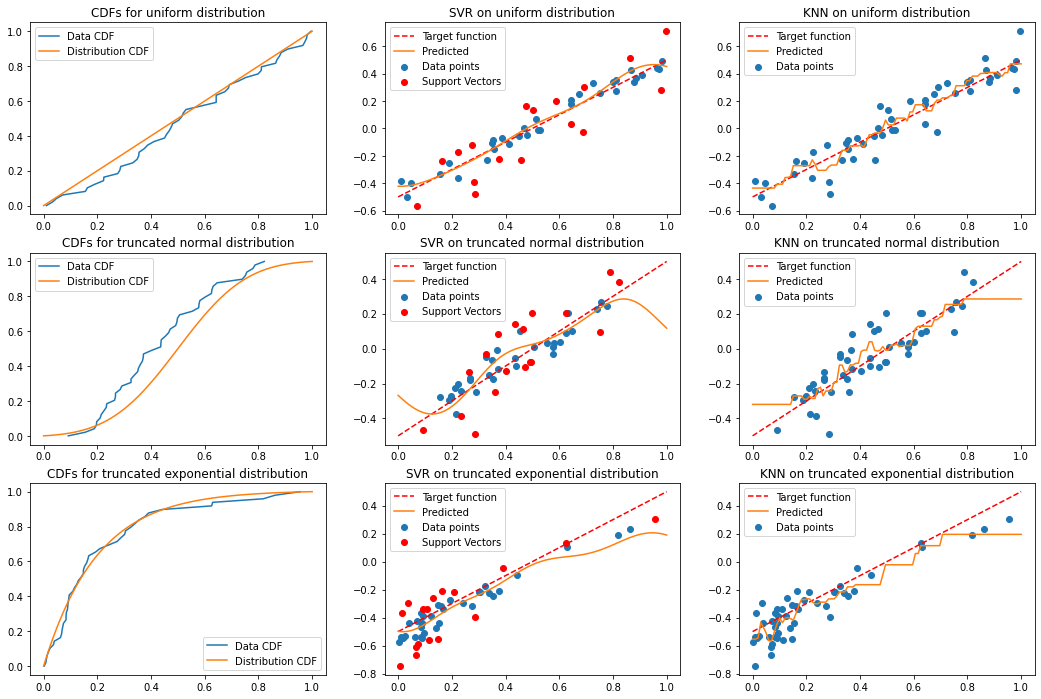

In [30]:
# I invite the reader to change the values below to look at the results for a different iterations
chosen_iteration = 1

df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)
print(f"\n\t\t---- Results for iteration {chosen_iteration} (mean_squared_error) ----")
plot_iteration_results(results[chosen_iteration])

The cell below shows that the we get similar results as above when:

1. We have more data
2. We have less data
3. We're using a linear kernel for SVR

In [31]:
print("-------- Baseline --------")
df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)

print("-------- More training data --------")
num_datapoints = 100
n_iterations = 100
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {}, {}))

df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)

print("-------- Less training data --------")
num_datapoints = 25
n_iterations = 200
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {}, {}))

df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)

print("-------- Using a linear kernel --------")
num_datapoints = 50
n_iterations = 100
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {'kernel':'linear'}, {}))

df = average_results(results)
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) ----\n", df)

-------- Baseline --------
		---- Average over 100 iterations (mean_squared_error) ----
                             SVR       KNN
Distributions                            
uniform                0.001955  0.002531
truncated normal       0.003289  0.002954
truncated exponential  0.004132  0.004035
-------- More training data --------
		---- Average over 100 iterations (mean_squared_error) ----
                             SVR       KNN
Distributions                            
uniform                0.000913  0.002125
truncated normal       0.001299  0.002221
truncated exponential  0.002032  0.002682
-------- Less training data --------
		---- Average over 200 iterations (mean_squared_error) ----
                             SVR       KNN
Distributions                            
uniform                0.004041  0.004493
truncated normal       0.006794  0.004929
truncated exponential  0.008676  0.007358
-------- Using a linear kernel --------
		---- Average over 100 iterations (mean_sq

From these experiments it is seems that on a linear dataset having uniformly distributed training data is preferable over a normally or exponentially distributed data. Now we can ask ourselves what we can do if our data isn't uniformly distributed. One solution would be to simply collect more data, preferably with the aim of making the dataset more uniformly distributed. However, it is not always possible to get more data so we'll have to look for another solution. We could also do the opposite; we could drop some of the data. This would be a valid solution if the accuracy you gain by making the dataset uniformly distributed is greater than the accuracy you lose by reducing the size of the training data. 

In the cell below we did a little experiment to check this theory. Here we compare having a uniform distribution with the non-uniformly distributed data that is twice the size. The idea behind it is that we got to the uniformly distributed dataset by dropping points from the other two. You might see in the plots below that even after dropping half the datapoints, the extrema of the non-uniformly distributed still look less dense than the uniformly distributed dataset. On top of that, we see that for the uniformly distributed data, the errors are higher for the other two. This suggests that we lose more accuracy by dropping data, then we would have gained for making it uniformly distributed.

-------- Reduced number of uniformly distributed points VS more non-uniformly distributed --------
		---- Average over 100 iterations (mean_squared_error) (Normal and Expontential have 100% more data) ----
                             SVR       KNN
Distributions                            
uniform                0.000207  0.002051
truncated normal       0.000140  0.002041
truncated exponential  0.000146  0.002044

		---- Results for iteration 0 (mean_squared_error) ----
           Distributions       SVR       KNN
0                uniform  0.000100  0.001954
1       truncated normal  0.000105  0.002484
2  truncated exponential  0.000105  0.001544


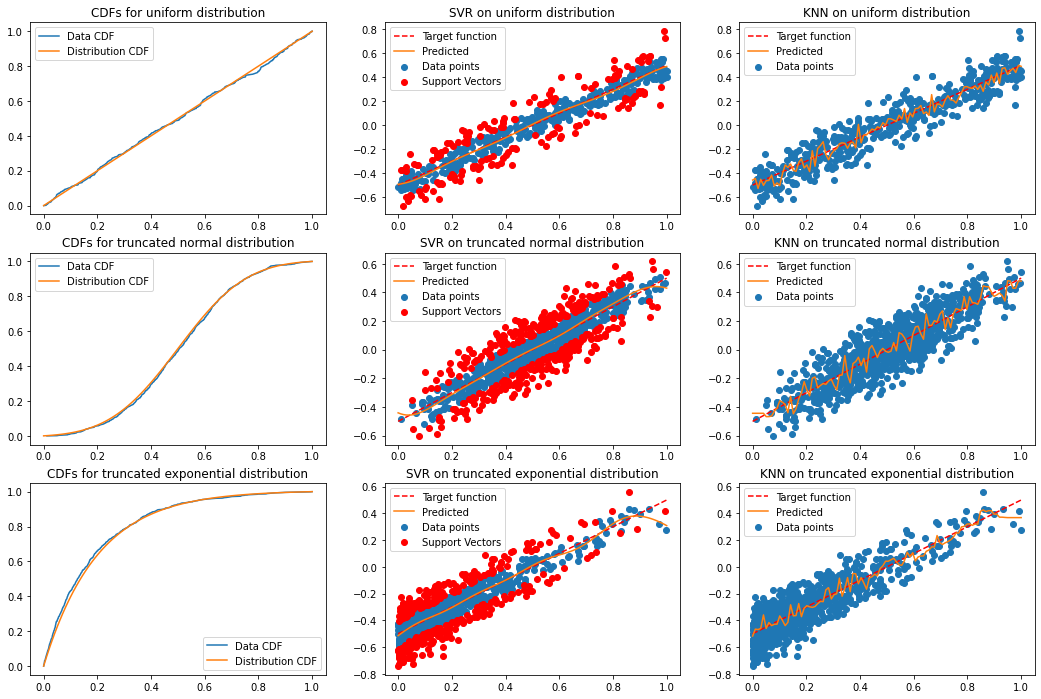

In [32]:
print("-------- Reduced number of uniformly distributed points VS more non-uniformly distributed --------")
num_datapoints = [500, 1000, 1000]
n_iterations = 100
results = []
for _ in range(n_iterations):
    # Target function
    target_function = lambda x: x - 0.5
    results.append(run_1_iteration(target_function, num_datapoints, {}, {}))


df = average_results(results)
chosen_iteration = 0
print(f"\t\t---- Average over {n_iterations} iterations (mean_squared_error) (Normal and Expontential have 100% more data) ----\n", df)
print(f"\n\t\t---- Results for iteration {chosen_iteration} (mean_squared_error) ----")
plot_iteration_results(results[chosen_iteration])

### Example on real dataset
Answering this research question is a challenging thing to do with real datasets since we don't have control over the distribution of the data. Nonetheless I will still apply these 2 algorithms to some real normally distributed datasets. The dataset we will be using consists of all kinds of different body measurements for possums. The plots in the cell below show how different features in the dataset compare to a normal distribution (with mean and standard deviation the mean and standard deviation of the data). Headlength, total length, tail length, eye size, chest girth and belly are all appear to be normally distributed. Using a statistical test we can confirm that the distributions of these features are not significantly different from a normal distribution.

*(data source = https://www.kaggle.com/datasets/abrambeyer/openintro-possum)*

C:\Users\elias\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2073: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\elias\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1491: RuntimeWarning: invalid value encountered in sign
  term2 = np.sign(denom) * np.where(denom == 0.0, np.nan,


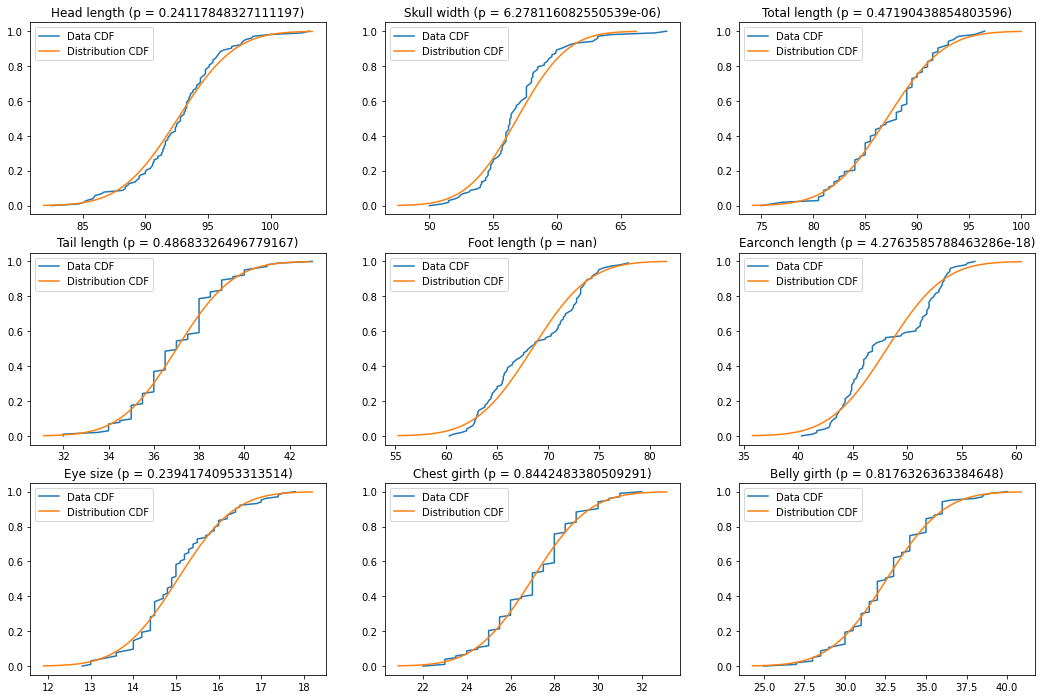

In [33]:
possum_data = pd.read_csv("openintro-possum/possum.csv")

#print(possum_data.head())
features = ["hdlngth", "skullw", "totlngth", "taill", "footlgth", "earconch", "eye", "chest", "belly"]
feature_display_name = ["Head length", "Skull width", "Total length", "Tail length", "Foot length", "Earconch length", "Eye size", "Chest girth", "Belly girth"]
fig, axs = plt.subplots(len(features)//3, 3)
multiply_fig_size(fig, len(features)//3, 3)

for feature, name, ax in zip(features, feature_display_name, axs.flatten()):
    feature_data = possum_data[feature]
    ax.set_title(f"{name} (p = {stats.normaltest(feature_data)[1]})")
    mean, std = feature_data.mean(), feature_data.std()
    length_distr = stats.norm(loc=mean, scale=std)
    plot_distrs(feature_data, length_distr, (mean-3*std, mean+3*std), ax)

We find many different regression tasks for this dataset. In this notebook we will look to predict a possum's skull width based on its total length.

(<module 'matplotlib.pyplot' from 'C:\\Users\\elias\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 <matplotlib.collections.PathCollection at 0x216d7c4a9a0>)

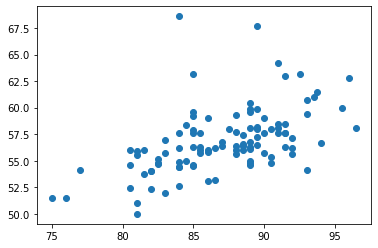

In [34]:
x = possum_data["totlngth"].to_numpy()
y = possum_data["skullw"].to_numpy()
plot_data(x, y)

Since we don't know the target function in this scenario, we can't generate datapoints for testing, and we'll have to set some of our data aside as a test set for later evaluation.

In [35]:
from sklearn.model_selection import train_test_split
# Setting the random state so the experiments results will be the same if the notebook is ran again
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)
x_train = x_train.reshape((-1, 1))
x_test = x_test.reshape((-1, 1))

We can now fine-tune the hyperparameters for our model. This can easily be done using a grid search with cross-validation on the training set. For SVR I manually checked every kernel to see which one performed best, which in this case was the linear kernel.

In [36]:
from sklearn.model_selection import GridSearchCV
# Kernels:  Linear  (0.39)
#           RBF     (0.33)
#           Poly    (0.38) (Really slow + didn't fine tune 'degree' hyperparameter)
#           Sigmoid (-0.03)
svr_gs = \
    GridSearchCV(SVR(), \
        {
            'epsilon': [0, 0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4],
            'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100],
            'kernel': ['linear']
        })
svr_gs_result = svr_gs.fit(x_train, y_train)

knn_gs = \
    GridSearchCV(KNeighborsRegressor(), \
        {
            'n_neighbors': [1, 2, 3, 5, 10, 15, 20, 25, 30],
            'weights': ['uniform', 'distance'],
        })
knn_gs_result = knn_gs.fit(x_train, y_train)

Best parameters for SVR: {'C': 0.1, 'epsilon': 2, 'kernel': 'linear'}, score: 0.39053408225082437
Best parameters for KNN: {'n_neighbors': 15, 'weights': 'uniform'}, score: 0.3082990091265153


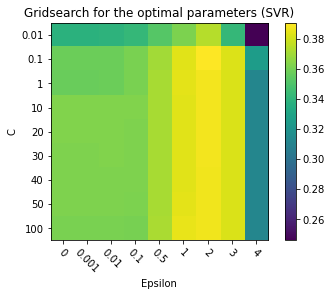

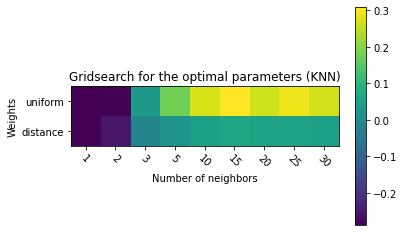

In [37]:
fig1, ax1 = plt.subplots(1, 1)
fig2, ax2 = plt.subplots(1, 1)

# Plot results for SVR
Epsilon, C = svr_gs_result.param_grid["epsilon"], svr_gs_result.param_grid["C"]

im = ax1.imshow(svr_gs_result.cv_results_["mean_test_score"].reshape(len(C), len(Epsilon)))
fig1.colorbar(im)

ax1.set_xlabel("Epsilon")
ax1.set_xticks(range(len(Epsilon)))
ax1.set_xticklabels(Epsilon, rotation=-45)
ax1.set_ylabel("C")
ax1.set_yticks(range(len(C)))
ax1.set_yticklabels(C)
ax1.set_title("Gridsearch for the optimal parameters (SVR)")

# Plot results for KNN
n_neighbors, weights = knn_gs_result.param_grid["n_neighbors"], knn_gs_result.param_grid["weights"]

im = ax2.imshow(np.transpose(knn_gs_result.cv_results_["mean_test_score"].reshape(len(n_neighbors), len(weights))))
fig2.colorbar(im)
ax2.set_xlabel("Number of neighbors")
ax2.set_xticks(range(len(n_neighbors)))
ax2.set_xticklabels(n_neighbors, rotation=-45)
ax2.set_ylabel("Weights")
ax2.set_yticks(range(len(weights)))
ax2.set_yticklabels(weights)
ax2.set_title("Gridsearch for the optimal parameters (KNN)")

svr_best_params = svr_gs_result.best_params_
print(f"Best parameters for SVR: {svr_gs_result.best_params_}, score: {svr_gs_result.best_score_}")

knn_best_params = knn_gs_result.best_params_
print(f"Best parameters for KNN: {knn_gs_result.best_params_}, score: {knn_gs_result.best_score_}")

Finally we examing the final hypothesis. Since we don't know the target function (if that were the case, why are we learning from data?), we can't calculated $E_{out}$. We can however estimate its value by evaluating on the test set. The scoring metric we use here (and during parameter tuning) is the coefficient of determination $R^2$. This is a measure of how well our model explains the variance in the data. A value of 1 means that the model perfectly predicts the data, and value of 0 means the model predicts the same outcome for every input. Since we have a value of around 0.12 for both models, this means the model does explain some of the variance in the data, but not all of it.

In the case of the KNN algorithm, we see the same effect of the normally distributed data as we had in the synthetic dataset experiments. For low and high length values, the prediction curve starts to flatten out, even though we might expect the target function to be linear (assuming possum's heads grow as they grow in length).

SVR's score on the test set: 0.12633035321124908
KNN's score on the test set: 0.12559070280229845


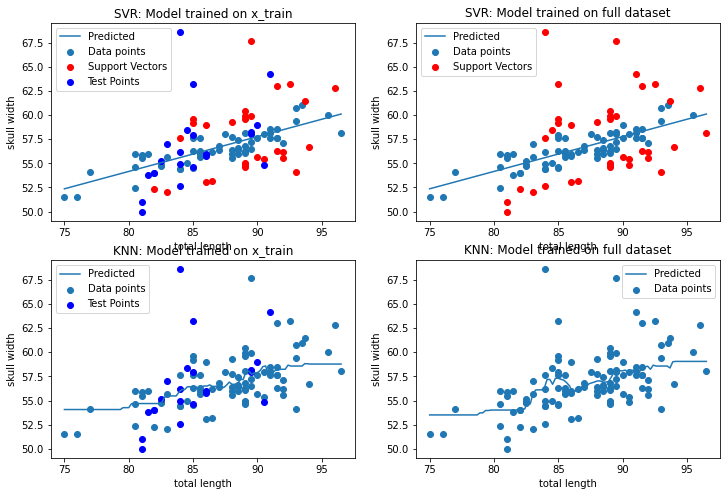

In [38]:
# Create some plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
multiply_fig_size(fig, 2, 2)
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel("total length")
    ax.set_ylabel("skull width")

# Fit models using the optimal parameters
svr = SVR(**svr_best_params)
svr.fit(x_train, y_train)
knn = KNeighborsRegressor(**knn_best_params)
knn.fit(x_train, y_train)

# Score the models on the test set
score = svr.score(x_test, y_test)
print(f"SVR's score on the test set: {score}")
score = knn.score(x_test, y_test)
print(f"KNN's score on the test set: {score}")

# Plot results for the train_data model...
ax1.set_title("SVR: Model trained on x_train")
plot_prediction(x_train, y_train, False, svr, ax=ax1)
ax1.scatter(x_test, y_test, c="b", label="Test Points")
ax1.legend()
ax3.set_title("KNN: Model trained on x_train")
plot_prediction(x_train, y_train, False, knn, ax=ax3)
ax3.scatter(x_test, y_test, c="b", label="Test Points")
ax3.legend()

# And the full data model
ax2.set_title("SVR: Model trained on full dataset")
plot_prediction(x, y, False, SVR(**svr_best_params).fit(x.reshape((-1, 1)), y), ax=ax2)
ax4.set_title("KNN: Model trained on full dataset")
plot_prediction(x, y, False, KNeighborsRegressor(**knn_best_params).fit(x.reshape((-1, 1)), y), ax=ax4)

### Conclusion
It is preferable to have uniformly distributed data when doing regression on a 1 dimensional features. If the data you have is not uniformly distributed, and no new data can be collected, just use the data you have.


## Research Question 3


## Research Question 3

The third research question concerns the comparison of the performances of different approaches to multi-label classification problems. In this notebook we will compare two different approaches. First we will solve multi-label classification problems using a problem transformation method. Afterwards, we will try to solve these same problems making use of an algorithm adapted to multi-label classification problems. Some background regarding multi-label classification problems and the different approaches to it will be covered first.

### Background

A multi-label classification problem is a classification problem in which we have more than one target output and where each target output has a cardinality of two. Take the following example in the context of movies: <br> <br>

Input features: metadata about the movie <br>
Output targets: labels regarding the category of the movie (e.g., horror, thriller, and comedy)
- Multiple labels => > 1 target output<br>
- A movie either belongs to the category ot not => each target has a cardinality of 2<br><br>

Multi-label classification problems become harder as the amount of output targets increase due to the rapidly increasing number of possible output combinations ($2^n$ with n = #targets). <br><br>

Multiple approaches to multi-label classification problems exist, this notebook will compare two of these approaches. First off, a problem transformation method. There are a variety of different problem transformation methods that we may use, but we will opt for a method that transforms our multi-label classification problem into multiple binary classification problems (one for each output target), also called the binary relevance method. This is the most trivial method when it comes to handling multi-label classification problems with an algorithm that does not inherently support multi-label classification. The major downside to this approach is that the individual classifiers do not hold any regard to any of the other target outputs, hence ignoring any possible correlations between the target outputs. <br> <br>
The second approach concerns using an algorithm that is specifically adapted to handle multi-label classification problems. The algorithm that we will be using is *Multilabel k Nearest Neighbours*, which will look at the k nearest neighbors and on the basis of Bayesian inference, select the assigned labels.
<br> <br> 
#### ML-KNN

We will know explain the Bayesian inference to select the labels of the target outputs in more detail. Let's define a membership counting vector, a vector that counts the number of neighboring data points with a given label $l$, as followed:

$$\vec{C_x}(l) = \sum_{a \in N(x)}\vec{y_a}(l), \;\;\; l \in Y$$

Where $Y$ is the set of all target outputs, and $\vec{y_a}(l)$ takes on a value in $\{0, 1\}$ corresponding to the value of target output $l$ of neighbor $a$. The value for a given target output $l$ of a given test instance $t$ may be predicted as followed:

$$\vec{y_t}(l) = argmax_{b \in \{0,1\}}P(H_b^l | E_{\vec{C_t}(l)}^l), \;\;\; l \in Y$$

Here, $H_b^l$ represents the event that $t$ has value $b \in \{0,1\}$ for target output $l$. $E_{\vec{C_t}(l)}^l$ denotes the event that exactly $\vec{C_t}(l)$ neighbors of $t$ have a value of 1 for target output $l$.

Using the Bayesian rule, the formula above can be rewritten into:

$$\vec{y_t}(l) = argmax_{b \in \{0,1\}}P(H_b^l)P(E_{\vec{C_t}(l)}^l | H_b^l)$$

The prior probabilities $P(H_b^l)$ and posterior probabilities $P(E_{\vec{C_t}(l)}^l | H_b^l)$ can be estimated through frequency counting on the training set.

<br> (source: http://scikit.ml/api/skmultilearn.adapt.mlknn.html).

### Synthetic data

We will start of by evaluating and comparing the performance of both approaches on synthetic datasets. As it is also interesting to compare how the approaches perform with an increasing number of output targets, we will be using several datasets ranging from 2 target outputs to 8 target outputs. The amount of input features will be set to 5 across all datasets.

In [19]:
# Some code to plot a 3D multi-label dataset w/ 2 target outputs

def plot_3D_dataset(ax, title, data_x, data_y):
    min_x = np.min(data_x[:, 0])
    max_x = np.max(data_x[:, 0])
    min_y = np.min(data_x[:, 1])
    max_y = np.max(data_x[:, 1])
    min_z = np.min(data_x[:, 2])
    max_z = np.max(data_x[:, 2])
    zero_class = np.where(data_y[:, 0])
    one_class = np.where(data_y[:, 1])
    ax.scatter3D(data_x[:, 0], data_x[:, 1], data_x[:, 2], s=40, c="gray", edgecolors=(0, 0, 0))
    ax.scatter3D( data_x[zero_class, 0],data_x[zero_class, 1],data_x[zero_class, 2],s=160,edgecolors="b",linewidths=2,label="Class 1", )
    ax.scatter3D( data_x[one_class, 0],data_x[one_class, 1],data_x[one_class, 2],s=80,edgecolors="orange",linewidths=2,label="Class 2",)
    ax.set_xlabel("First feature")
    ax.set_ylabel("Second feature")
    ax.set_zlabel("Third feature")
    ax.legend(loc="upper left")
    ax.set_title(title, fontsize=20)
    ax.set_xlim(min_x - 0.01, max_x + 0.01)
    ax.set_ylim(min_y - 0.01, max_y + 0.01)
    ax.set_zlim(min_z - 0.01, max_z + 0.01)
    

In the plot below, a dataset with 3 input features and 2 target outputs is visualized. This dataset will not be used to train our models but visualizes the multi-labeling problem at hand.

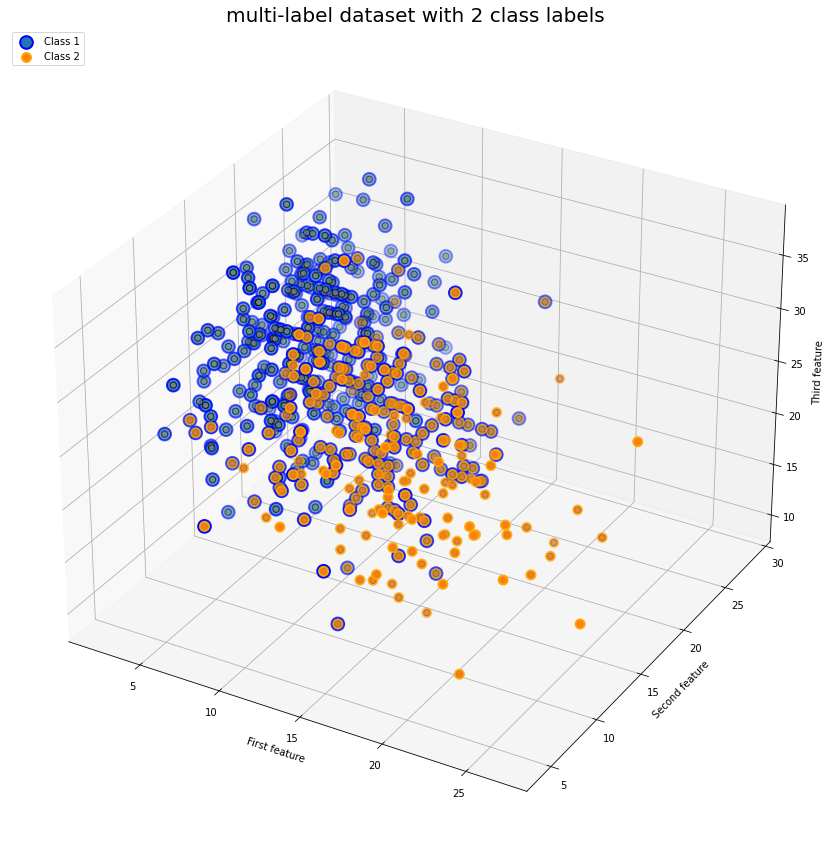

In [20]:
from sklearn.datasets import make_multilabel_classification

data_x, data_y = make_multilabel_classification(n_samples=500, n_features=3, n_classes=2, n_labels=1, allow_unlabeled=False, random_state=123)
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
plot_3D_dataset(ax, "multi-label dataset with 2 class labels", data_x, data_y)
fig.patch.set_width(20)

In [41]:
def calculate_powerlabel(classes, y):
    idx = 1
    powerlabel = 0
    for i in range(classes):
        powerlabel += y[classes-(i+1)] * idx
        idx = idx * 2
    return powerlabel

def balance_multilabel_dataset(synthetic_data_x, synthetic_data_y, classes):
    synthetic_data_y['powerlabel'] = synthetic_data_y.apply(lambda x : calculate_powerlabel(classes, x),axis=1)
    synthetic_data = pd.concat([synthetic_data_x, synthetic_data_y], axis=1)
    powercount = {}
    powerlabels = np.unique(synthetic_data['powerlabel'])
    for p in powerlabels:
        powercount[p] = np.count_nonzero(synthetic_data['powerlabel']==p)
    maxcount = np.max(list(powercount.values()))
    for p in powerlabels:
        pc = powercount[p]
        if pc < maxcount:
            minority_upsampled = resample(synthetic_data[synthetic_data['powerlabel']==p], replace=True, n_samples=maxcount, random_state=123) 
            synthetic_data = pd.concat([synthetic_data[synthetic_data['powerlabel']!=p], minority_upsampled])
        
    synthetic_data = synthetic_data.sample(frac=1).reset_index(drop=True)
    synthetic_data_x = synthetic_data.iloc[:,:-(classes+1)]
    synthetic_data_y = synthetic_data.iloc[:,len(synthetic_data_x.columns):-1]
    
    return synthetic_data_x, synthetic_data_y

When using multi-label datasets, imbalance across the different combinations of target outputs is a common issue. The combination imbalances for each of our datasets are shown in the plots below. In these examples, the imbalances are relatively acceptable since no combination predominantly occurs. In the case of 8 target outputs, the most frequent combination still only appears around 3 percent of the time. We have tried to balance our data by upsampling each combination (corresponds to a unique powerlabel) to the frequency of the most frequent combination. This approach, however, did not result in any significant improvements over using the imbalanced data. Due to this reason and the massive increase in training data, we have decided to leave out the balancing in our final experimental setup. The balancing can, however, easily be applied again by uncommenting the respective line in the code below. We have also tried to apply other balancing techniques, such as MLSMOTE. While this technique did not deliver significant results on the synthetic data, it showed drastic changes in the learned hypothesis when applied to the real-life dataset which will be discussed later.

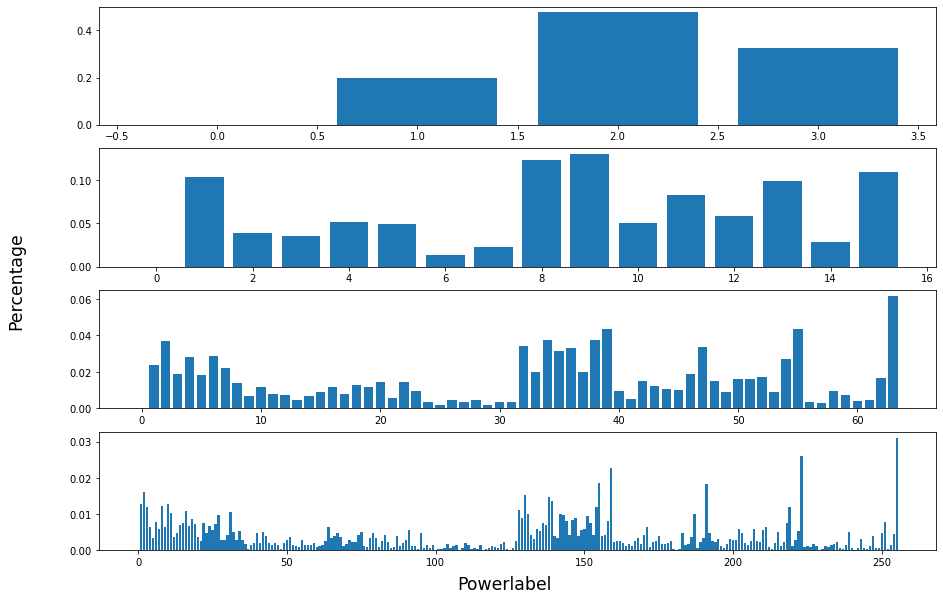

In [42]:
scaler_sd = StandardScaler()

synthetic_training_datasets_per_number_of_classes = []
synthetic_testing_datasets_per_number_of_classes = []

fig, axs = plt.subplots(4, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.text(0.5, 0.07, 'Powerlabel', ha='center', fontsize='xx-large')
fig.text(0.04, 0.5, 'Percentage', va='center', rotation='vertical', fontsize='xx-large')

for idx, classes in enumerate([2, 4, 6, 8]):
    data_x, data_y = make_multilabel_classification(n_samples=5000, n_features=5, n_classes=classes, n_labels=classes/2, allow_unlabeled=False, random_state=123)
    scaler_sd.fit(data_x)
    data_x = scaler_sd.transform(data_x)
    synthetic_data_x = pd.DataFrame(data_x)
    synthetic_data_y = pd.DataFrame(data_y)
    synthetic_data_x_train, synthetic_data_x_test, synthetic_data_y_train, synthetic_data_y_test = train_test_split(synthetic_data_x, synthetic_data_y, test_size=0.3,random_state=44)
    
    # Balancing of powerlabels
    #synthetic_data_x_train, synthetic_data_y_train = balance_multilabel_dataset(synthetic_data_x_train, synthetic_data_y_train, classes) 
    
    synthetic_training_datasets_per_number_of_classes += [(synthetic_data_x_train, synthetic_data_y_train)]
    synthetic_testing_datasets_per_number_of_classes += [(synthetic_data_x_test, synthetic_data_y_test)]
    
    train_labels_copy = synthetic_data_y_train.copy()
    train_labels_copy['powerlabel'] = train_labels_copy.apply(lambda x : calculate_powerlabel(classes, x),axis=1)
    imbalance = []
    total_powerlabels = int(calculate_powerlabel(classes, np.ones(classes)))+1
    for i in range(total_powerlabels):
        imbalance += [train_labels_copy[train_labels_copy['powerlabel']==i].count()[0]/train_labels_copy['powerlabel'].count()]
    axs[idx].bar(range(total_powerlabels), imbalance)
    

In [50]:
svc_gs = \
    GridSearchCV(MultiOutputClassifier(svm.SVC(), n_jobs=-1), \
        {
            'estimator__C': [0.001, 0.01, 0.1, 1, 10],
            'estimator__kernel': ["linear", "rbf"]
        }, scoring=make_scorer(skl.metrics.hamming_loss, greater_is_better=False))

knn_gs = \
    GridSearchCV(MLkNN(), \
        {
            'k': [10, 30, 50, 100],
            's': [0, 0.5, 1],
        }, scoring=make_scorer(skl.metrics.hamming_loss, greater_is_better=False))

In [44]:
def analyse_results(Y_pred, Y_test):
    diff = Y_pred - Y_test
    
    diffr = np.sum(abs(diff), axis=0)/len(Y_test)
    pos_in_test = np.sum(Y_test, axis=0)/len(Y_test)
    pos_in_pred = np.sum(Y_pred, axis=0)/len(Y_test)
    true_pos = np.sum(Y_pred + Y_test == 2, axis=0)/len(Y_test)
    false_pos = np.sum(diff > 0, axis=0)/len(Y_test)
    true_neg = np.sum(Y_pred + Y_test == 0, axis=0)/len(Y_test)
    false_neg = np.sum(diff < 0, axis=0)/len(Y_test)
    results_df = pd.DataFrame(
        np.transpose(np.array([diffr, true_pos, true_neg, false_pos, false_neg, pos_in_test, pos_in_pred], dtype=object)), 
        columns=['error', 'true_pos', 'true_neg', 'false_pos', 'false_neg', 'pos_in_test', 'pos_in_pred'])
    return results_df

The code below follows our first approach. We transform our multi-label classification problem into multiple binary classification problems by using *MultiOutputClassifier* on the *SVC* model. *MultiOutputClassifier* will fit one *SVC* model per target, the outputs of our test set are then predicted by the union of the outputs of each of these models. We should be cautious of what scoring metric to use to evaluate our model. The generic *accuracy_score* will not be suitable for our purposes as it will only take into account the predictions that perfectly match the correct combination of target outputs. We would rather have some notion of how close we are to the correct combination of target outputs. Therefore we will be using the Hamming loss metric, which is the fraction of labels that are incorrectly predicted (the lower the Hamming loss, the better our predictions).

--- Multi-output SVC with Hamming loss scorer ---
Grid search optimal parameters:  {'estimator__C': 0.01, 'estimator__kernel': 'linear'}
Hamming loss test set:  0.10666666666666667
       error  true_pos  true_neg false_pos  false_neg pos_in_test pos_in_pred
0  0.0793333  0.788667     0.132     0.052  0.0273333       0.816    0.840667
1      0.134  0.433333  0.432667     0.042      0.092    0.525333    0.475333
---------------------------------------------------
--- Multi-output SVC with Hamming loss scorer ---
Grid search optimal parameters:  {'estimator__C': 1, 'estimator__kernel': 'rbf'}
Hamming loss test set:  0.24
      error  true_pos  true_neg  false_pos  false_neg pos_in_test pos_in_pred
0  0.223333  0.642667     0.134       0.18  0.0433333       0.686    0.822667
1  0.219333     0.292  0.488667       0.06   0.159333    0.451333       0.352
2     0.248  0.198667  0.553333  0.0726667   0.175333       0.374    0.271333
3  0.269333  0.526667     0.204   0.201333      0.068    0.59

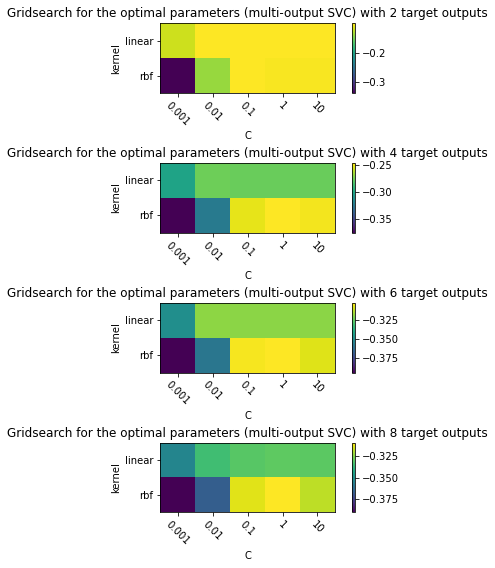

In [45]:
fig, ax = plt.subplots(4, 1, figsize=(6, 9))
fig.subplots_adjust(hspace=1)

for idx, ((training_data_x, training_data_y), (test_data_x, test_data_y)) in enumerate(zip(synthetic_training_datasets_per_number_of_classes, synthetic_testing_datasets_per_number_of_classes)):
    svc_gs.fit(training_data_x, training_data_y)
    print("--- Multi-output SVC with Hamming loss scorer ---")
    print("Grid search optimal parameters: ", svc_gs.best_params_)
    synthetic_data_y_pred = svc_gs.predict(test_data_x)
    score = metrics.hamming_loss(test_data_y, synthetic_data_y_pred)
    results = analyse_results(pd.DataFrame(np.array(synthetic_data_y_pred)), pd.DataFrame(np.array(test_data_y)))
    print("Hamming loss test set: ", score)
    print(results)
    print("---------------------------------------------------")
    C, kernel = svc_gs.param_grid["estimator__C"], svc_gs.param_grid["estimator__kernel"]
    im = ax[idx].imshow(np.transpose(svc_gs.cv_results_["mean_test_score"].reshape(len(C), len(kernel))), interpolation='nearest')
    fig.colorbar(im, ax=ax[idx])
    ax[idx].set_xlabel("C")
    ax[idx].set_xticks(range(len(C)))
    ax[idx].set_xticklabels(C, rotation=-45)
    ax[idx].set_ylabel("kernel")
    ax[idx].set_yticks(range(len(kernel)))
    ax[idx].set_yticklabels(kernel)
    ax[idx].set_title("Gridsearch for the optimal parameters (multi-output SVC) with " + str((idx+1)*2) + " target outputs")

The Hamming losses for each dataset are given above, we can clearly see that as the amount of target outputs increases, the hamming loss increases as well. The error percentage per target output is also given for each dataset, the Hamming loss can also be defined as the mean of these error percentages. While the default score metric would result in an extremely low accuracy for the model with 8 target outputs, the Hamming loss metric is able to show that on average each target has around a 30 percent chance to be labeled incorrect. We may see that due to the imbalance of the dataset, the model tends to choose the same value for certain target outputs (e.g., feature 2 in dataset with 8 target outputs). Setting the class_weight to *balanced* for the SVC solves this issue, but the grid search would still opt for the model without regard for class imbalance as its Hamming loss is smaller.

The code below follows our second approach, namely using KNN adapted to multi-label classification. We once again use the Hamming loss as our metric of choice here.

NameError: name 'synthetic_training_datasets_per_number_of_classes' is not defined

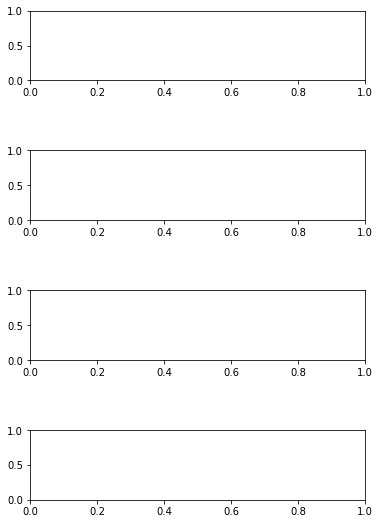

In [3]:
# ignore warnings thrown by MLkNN
simplefilter(action='ignore', category=FutureWarning)
fig, ax = plt.subplots(4, 1, figsize=(6, 9))
fig.subplots_adjust(hspace=1)

for idx, ((training_data_x, training_data_y), (test_data_x, test_data_y)) in enumerate(zip(synthetic_training_datasets_per_number_of_classes, synthetic_testing_datasets_per_number_of_classes)):
    knn_gs_result = knn_gs.fit(np.array(training_data_x), np.array(training_data_y))
    synthetic_data_y_pred = knn_gs_result.predict(test_data_x).toarray()
    score = metrics.hamming_loss(pd.DataFrame(np.array(test_data_y)), pd.DataFrame(synthetic_data_y_pred))
    results = analyse_results(pd.DataFrame(synthetic_data_y_pred), pd.DataFrame(np.array(test_data_y)))
    print("--- MLkNN with Hamming loss scorer ---")
    print("Grid search optimal parameters: ", knn_gs_result.best_params_)
    print("Hamming loss test set: ", score)
    print(results)
    print("---------------------------------------------------")
    k, s = knn_gs_result.param_grid["k"], knn_gs_result.param_grid["s"]
    im = ax[idx].imshow(np.transpose(knn_gs_result.cv_results_["mean_test_score"].reshape(len(k), len(s))), interpolation='nearest')
    fig.colorbar(im, ax=ax[idx])
    ax[idx].set_xlabel("k")
    ax[idx].set_xticks(range(len(k)))
    ax[idx].set_xticklabels(k, rotation=-45)
    ax[idx].set_ylabel("s")
    ax[idx].set_yticks(range(len(s)))
    ax[idx].set_yticklabels(s)
    ax[idx].set_title("Gridsearch for the optimal parameters (MLkNN) with " + str((idx+1)*2) + " target outputs")

While we may have expected that the MlKNN model would have better scores than the multi-output SVC model since MlKNN is directly adapted to the multi-labeling classification problem at hand, the results shown above are very similar, even slightly worse, to the ones we witnessed during the evaluation of the multi-output SVC model. We can once again witness the same behavior for some target outputs due to the class imbalance. The reason why we may witness similar results might be due to the fact that the target outputs are uncorrelated for our datasets, in which case the downside of the problem transformation method in our first approach does not apply for our datasets. We may check the correlations between our target outputs by using the Pearson's correlations.

In the matrix below the correlations between the different target outputs for one of our datasets are visualized. The target outputs are indeed are extremely uncorrelated, reinforcing our suspicions.

In [ ]:
plt.figure(ctr, figsize=(12,10))
x, y = synthetic_training_datasets_per_number_of_classes[1]
sns.heatmap(y.corr(), annot=True)
plt.title("Peason's correlations between target outputs from dataset with 8 targets", fontsize="x-large")
plt.show()

### Experiments on real data

For the real data part of this research question we will be using the foodtruck dataset (Rivolli, A. et al. 2017). The dataset contains the results of a questionnaire about food truck preferences. It contains a total of 407 instances, 1 for each person answering the questionnaire, 21 attributes, and 12 labels. The list below gives a short explanation for each of the attributes and labels:
| attribute(s)/labels | Explanation |
| --- |---  |
|frequency|Frequency of eating at a food truck (0: rarely, 1: monthly, 2: weekly, 3: twice a week, 4: daily)|
|time|Prefered time to eat at a food truck.|
|expenses|How much money they spend (number is the maximum amount of money in Brazilian reals.|
|motivation|In the paper this is explained as "what is the motivation", I'm not too sure what this means.|
|taste, hygiene, menu, presentation, attendance, ingredients, place.to.sit, takeaway, variation, stop.strucks (sic), schedule| How important do they find these 11 different qualities of a food truck on a scale of 1-5 (more information can be found in the paper).|
|gender, age.group, scholarity, average.income, has.work, marital.status| Answers to the 6 profiling questions |
|arabic_food, brazilian_food, chinese_food, street_food, fitness_food, gourmet, healthy_food, italian_food, japanese_food, mexican_food, snacks, sweets_desserts|Food preference of the person (binary, multiple can be selected)|

Using this dataset we want to be able to recommend to a new person some food truck choices that they might like. Since we can recommend multiple different types of food for 1 individual, this will be a multi-label classification problem. The barplot in the graph below shows the percentage of people that chose each food option in the dataset.

Most of the features in the data have already been converted to some ordinal scale (e.g. importance of different foodtruck qualities) but others (e.g. time or motivation) are still categorical features on the nominal scale. We convert each of these categorical features to different features using a One-Hot Encoder. This will take a categorical feature with $x$ possible values and transform it to $x$ binary features, one for each possible value.

In [ ]:
# From https://www.uco.es/kdis/mllresources/#FoodtruckDesc
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import type_of_target

foodtruck_data = arff.loadarff('foodtruck/foodtruck.arff')
df = pd.DataFrame(foodtruck_data[0])
all_labels = ['arabic_food', 'brazilian_food', 'chinese_food', 'street_food', 'fitness_food', 'gourmet', 'healthy_food', 'italian_food', 'japanese_food', 'mexican_food', 'snacks', 'sweets_desserts']
labels = all_labels
all_features = list(set(df.columns).difference(all_labels))
features = all_features

# --- Map labels to different datatype ---
for label in all_labels:
    df[label] = df[label].astype(int)

for attribute in ["time", "motivation", "gender", "marital.status"]:
    df[attribute] = df[attribute].astype(str)
    df[attribute] = df[attribute].map(lambda s: s[2:-1])

# --- Plot data imbalance ---
fig, ax = plt.subplots(1,1)
barplt = ax.bar(labels, [df[label].to_numpy().sum()/len(df) for label in labels])
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=-80)
ax.set_title("Percentage of people that chose each food option")
ax.set_xlabel("Food Option")
ax.set_ylabel("Percentage")

#X = X.drop(["time", "motivation", "taste", "hygiene", "menu", "presentation", "attendance", "ingredients", "place.to.sit", "takeaway", "variation", "stop.strucks", "schedule"], axis=1)
#print(type_of_target(Y))

# --- Preprocessing ---
X = df[features]
Y = df[labels]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_attributes = ['time', 'motivation', 'gender', 'marital.status']
preprocessor = ColumnTransformer(
    transformers=[('categorical', OneHotEncoder(), categorical_attributes)],
    remainder='passthrough'
    )

X_trans = pd.DataFrame(preprocessor.fit_transform(X, Y))
Y_trans = Y
X_train, X_test, Y_train, Y_test = train_test_split(X_trans, Y_trans, test_size=0.2, random_state=3, shuffle=False)
X_train = pd.DataFrame(X_train)
Y_train = pd.DataFrame(Y_train)
#print(X_train.head())

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

def analyse_results(Y_pred, Y_test):
    diff = Y_pred - Y_test
    
    diffr = np.sum(abs(diff), axis=0)/len(Y_test)
    pos_in_test = np.sum(Y_test, axis=0)/len(Y_test)
    pos_in_pred = np.sum(Y_pred, axis=0)/len(Y_test)
    true_pos = np.sum(Y_pred + Y_test == 2, axis=0)/len(Y_test)
    false_pos = np.sum(diff > 0, axis=0)/len(Y_test)
    true_neg = np.sum(Y_pred + Y_test == 0, axis=0)/len(Y_test)
    false_neg = np.sum(diff < 0, axis=0)/len(Y_test)
    results_df = pd.DataFrame(
        np.transpose(np.array([diffr, true_pos, true_neg, false_pos, false_neg, pos_in_test, pos_in_pred], dtype=object)), 
        columns=['error', 'true_pos', 'true_neg', 'false_pos', 'false_neg', 'pos_in_test', 'pos_in_pred'])
    return results_df

def plot_gs(gs_results, p1, p2, title, ax):
    p1s, p2s = gs_results.param_grid[p1], gs_results.param_grid[p2]
    im = ax.imshow(np.transpose(gs_results.cv_results_["mean_test_score"].reshape(len(p1s), len(p2s))))
    fig.colorbar(im)
    ax.set_xlabel(p1)
    ax.set_xticks(range(len(p1s)))
    ax.set_xticklabels(p1s, rotation=-45)
    ax.set_ylabel(p2)
    ax.set_yticks(range(len(p2s)))
    ax.set_yticklabels(p2s)
    ax.set_title(title)
    return ax

f1_scorer = make_scorer(skl.metrics.f1_score, average='weighted', zero_division=0)
hamming_loss_scorer = make_scorer(skl.metrics.hamming_loss, greater_is_better=False)


When we want to tune our hyperparemeters using a gridsearch, we need to specify a scoring metric that our models will be evaluated with. We started with the accuracy score that comes as a default with our models. 

In [ ]:
# Estimated runtime: 51s
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

knn_pipe = Pipeline([
    #('preprocessor', preprocessor),
    ('knn', MLkNN())
])

knn_gs = \
    GridSearchCV(knn_pipe, \
        {
            'knn__k': [1, 2, 5, 10, 20, 50, 100, 150, 200, 250],
            'knn__s': [0, 0.5, 1],
        }, scoring=hamming_loss_scorer
        )

knn_gs_result = knn_gs.fit(X_train, np.array(Y_train))

One of the issues that occurs when we use this scoring metric is that our model learns a very uninteresting hypothesis. As you can see in the cell below, the gridsearch results finds the optimal value for k (the number of neighbors) to be 250, which is almost the same as the size of the training dataset! This results in a learned hypothesis that (almost) always gives the same classifications. You can see this in the table produced by the cell below. This table contains 1 row for each label in the data and shows for each of these labels a couple of values. The values in the columns are for each label: the fraction of misclassifications, the fraction of true positives, the fraction of true negatives, the fraction of false negatives, the fraction of false negatives, the fraction of positive classifications in the test set, and the fraction of positive classification in the predictions.

In the last column of this table you can see that the model always predicts label 3 (street_food) to be positive and it almost always predicts the other labels to be negative. As we'll see in the next couple of cells, this is not a limitation of the MLkNN algorithm, but instead a result of our dataset being imbalanced and chosen scoring metric.

In [ ]:
fig, ax = plt.subplots(1, 1)
print("--- MLkNN with hamming_loss scorer ---")
print(knn_gs_result.best_params_)

# --- Plot grid search results ---
plot_gs(knn_gs_result, 'knn__k', 'knn__s', "Gridsearch for the optimal parameters (KNN)", ax)

# --- Evaluate ---
#knn_pipe.fit(np.array(X_train), np.array(Y_train))
Y_pred = knn_gs.best_estimator_.predict(X_test).toarray()

print("hamming loss score: ", hamming_loss_scorer(knn_gs_result.best_estimator_, X_test, Y_test))

print("--- Label information  ---")
results = analyse_results(pd.DataFrame(np.array(Y_pred)), pd.DataFrame(np.array(Y_test)))
print("Mean error: ", np.mean(results["error"]))
results

Since the default accuracy_score metric provided very unsatisfactory results, we changed to a different metric. In the cell below we do the same gridsearch, this time using the f1_score metric.

In [ ]:
# Estimated runtime: 51s
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

knn_pipe = Pipeline([
    #('preprocessor', preprocessor),
    ('knn', MLkNN())
])

knn_gs = \
    GridSearchCV(knn_pipe, \
        {
            'knn__k': [1, 2, 5, 10, 20, 50, 100, 150, 200, 250],
            'knn__s': [0, 0.5, 1],
        }, scoring=f1_scorer
    )

knn_gs_result = knn_gs.fit(X_train, np.array(Y_train))

This time the gridsearch ends up finding 1 to be the optimal value for $k$. With such a low value for $k$ there is a good chance the model is overfitting. Looking at the table in the cell below we see that the model is now predicting positive values for these other labels aswell, at the cost of also increasing the number of false positives. When we look at the mean of all the error fractions, we see that it is above 0.05 higher than when we used the accuracy scoring metric.

In [ ]:
fig, ax = plt.subplots(1, 1)
print("--- MLkNN with f1 scorer ---")
print("Grid search optimal parameters: ", knn_gs_result.best_params_)

# --- Plot grid search results ---
plot_gs(knn_gs_result, 'knn__k', 'knn__s', "Gridsearch for the optimal parameters (KNN)", ax)

# --- Evaluate ---
#knn_pipe.fit(np.array(X_train), np.array(Y_train))
Y_pred = knn_gs.best_estimator_.predict(X_test).toarray()

print("f1_score: ", f1_scorer(knn_gs.best_estimator_, X_test, Y_test))
#print(np.sum([all(clas == np.array([0,0,0,1,0,0,0,0,0,0,0,0])) for clas in np.array(Y_test)])/len(Y_test))

print("--- Label information  ---")
results = analyse_results(pd.DataFrame(np.array(Y_pred)), pd.DataFrame(np.array(Y_test)))
print("Mean error: ", np.mean(results["error"]))
results

We see the same results for the SVC algorithm. Here there parameter that controls the amount of regularisation is $C$. Again, we see that when we use the default accuracy score, the gridsearch finds low $C$ (high regularisation) to get the highest scores. However, when we use the f1 score, the grid search leads to low values for $C$ (low regularisation). 

In [ ]:
# Estimated runtime: 7s
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler

svc_pipe = Pipeline([
    #('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('svc', MultiOutputClassifier(SVC()))
])

svc_gs = \
    GridSearchCV(svc_pipe, \
        {
            'svc__estimator__C': [1e-20, 1e-10, 1e-02, 5e-02, 1e-01, 5e-01, 1, 2, 5, 10, 20, 50, 100],
            'svc__estimator__kernel': ['rbf', 'linear']
        })

svc_gs_result = svc_gs.fit(X_train, Y_train)

Notice the we see the same thing that happened when using this scoring metric with MLkNN. In this case the effect is even worse.

In [ ]:
fig, ax = plt.subplots(1, 1)
print("--- SVC with hamming loss scorer ---")
print("Grid search optimal parameters: ", svc_gs_result.best_params_)

# --- Plot grid search results ---
plot_gs(svc_gs_result, 'svc__estimator__C', 'svc__estimator__kernel', 
    "Gridsearch for the optimal parameters (SVC)", ax)

# --- Evaluate ---
#knn_pipe.fit(np.array(X_train), np.array(Y_train))
Y_pred = svc_gs.best_estimator_.predict(X_test)

print("hamming loss score: ", svc_gs.best_estimator_.score(X_test, Y_test))
#print(np.sum([all(clas == np.array([0,0,0,1,0,0,0,0,0,0,0,0])) for clas in np.array(Y_test)])/len(Y_test))

print("--- Label information  ---")
results = analyse_results(pd.DataFrame(np.array(Y_pred)), pd.DataFrame(np.array(Y_test)))
print("Mean error: ", np.mean(results["error"]))
results

Now we do SVC with the f1 scoring.

In [ ]:
# Estimated runtime: 7s
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler

svc_pipe = Pipeline([
    #('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('svc', MultiOutputClassifier(SVC()))
])

svc_gs = \
    GridSearchCV(svc_pipe, \
        {
            'svc__estimator__C': [1e-20, 1e-10, 1e-02, 5e-02, 1e-01, 5e-01, 1, 2, 5, 10, 20, 50, 100],
            'svc__estimator__kernel': ['rbf', 'linear']
        }, scoring=f1_scorer)

svc_gs_result = svc_gs.fit(X_train, Y_train)

Same results as using f1 scoring with MLkNN.

In [ ]:
fig, ax = plt.subplots(1, 1)
print("--- SVC with f1_score ---")
print("Grid search optimal parameters: ", svc_gs_result.best_params_)

# --- Plot grid search results ---
plot_gs(svc_gs_result, 'svc__estimator__C', 'svc__estimator__kernel', 
    "Gridsearch for the optimal parameters (SVC)", ax)

# --- Evaluate ---
#knn_pipe.fit(np.array(X_train), np.array(Y_train))
Y_pred = svc_gs.best_estimator_.predict(X_test)

print("F1 score: ", f1_scorer(svc_gs.best_estimator_, X_test, Y_test))
#print(np.sum([all(clas == np.array([0,0,0,1,0,0,0,0,0,0,0,0])) for clas in np.array(Y_test)])/len(Y_test))

print("--- Label information  ---")
results = analyse_results(pd.DataFrame(np.array(Y_pred)), pd.DataFrame(np.array(Y_test)))
print("Mean error: ", np.mean(results["error"]))
results

So why do both models underfit when we use the default accuracy score metric? To explain this we need to look at the distribution of the labels. The cell below print the top 10 most frequently occuring labellings and their fraction of occurence. As you can see, the dataset is dominated by instances that are labelled $[0,0,0,1,0,0,0,0,0,0,0,0]$. Since the accuracy scoring metric only considers an instance to be correctly classified if all its labels are correctly classified, the model can get a score of $0.2892$ by simply always predicting this labelling. This is exactly what we see happen, the maximum score reached in the gridsearch is exactly $0.289$ for both SVC and MLkNN.

In [ ]:
def top_n_labellings(Y, n):
    labellings = np.unique(Y, axis=0)
    labelling_occurences = np.array([np.sum([all(clas == labelling) for clas in np.array(Y)])/len(Y) for labelling in labellings])
    sorting = np.argsort(labelling_occurences)
    labellings, labelling_occurences = labellings[sorting], labelling_occurences[sorting]
    for i in range(n):
        print(labellings[len(labellings) - i - 1], " - ", labelling_occurences[len(labellings) - i - 1])

print("Number of unique labelling combinations:", len(np.unique(Y, axis=0)), "\nTotal number of possible combinations:", 2**12)
print("Training set")
top_n_labellings(Y_train, 10)
print("Complete dataset")
top_n_labellings(Y, 10)

**REWRITE**

As the plot above clearly shows, there is a large label imbalance in this dataset. A lot of people said they liked street_food, gourmet, and sweets/deserts, but only a small amount of people chose the other options. This leads can lead to issues when learning later on. To resolve this we tried some over-sampling techniques to balance the dataset by increasing the number of occurences of the other labels. The first solution we found was MLSMOTE, which is a multi-label adaption of SMOTE (Synthetic Minority Over-sampling Technique). In this new dataset, the number of times each combination of labels occurs has been balanced.
However, since this dataset doesn't contain many of the possible label combinations, the results of this balancing still leaves us with an unbalanced individual label frequencies. 

In [ ]:
from MLSMOTE import mlsmote

X_sub, Y_sub = mlsmote.get_minority_instace(pd.DataFrame(X_train), pd.DataFrame(Y_train))
X_resampled, Y_resampled = mlsmote.MLSMOTE(X_sub, Y_sub, 1000)

print("Length of X_train after upscaling:", len(X_resampled), " - Length of Y_train after upscaling:", len(Y_resampled))
fig, ax = plt.subplots(1,1)
barplt = ax.bar(labels, [Y_resampled[label].to_numpy().sum()/len(Y_resampled) for label in labels])
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=-80)
ax.set_title("Percentage of people that chose each food option (After resampling using MLSMOTE)")
ax.set_xlabel("Food Option")
ax.set_ylabel("Percentage")

print("Resampled set")
top_n_labellings(Y_resampled, 10)

Let us now repeat the gridsearch experiments from the cell above, this time on the newly balanced dataset. Since this dataset is slightly larger than the previous one, the training and therefore the gridsearch will take longer. I'll limit the size of the parameter grid we're searching through, simply to save time.

In [ ]:
# Estimated runtime: 3m30s
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

knn_pipe = Pipeline([
    #('preprocessor', preprocessor),
    ('knn', MLkNN())
])

knn_gs = \
    GridSearchCV(knn_pipe, \
        {
            'knn__k': [1, 2, 5, 10, 20, 100, 200, 250],
            'knn__s': [0, 1],
        }, scoring=hamming_loss_scorer
    )

knn_gs_result = knn_gs.fit(X_resampled, np.array(Y_resampled))

fig, ax = plt.subplots(1, 1)
print("--- MLkNN with hamming loss scorer (balanced dataset) ---")
print(knn_gs_result.best_params_)

# --- Plot grid search results ---
plot_gs(knn_gs_result, 'knn__k', 'knn__s', "Gridsearch for the optimal parameters (KNN)", ax)

# --- Evaluate ---
#knn_pipe.fit(np.array(X_train), np.array(Y_train))
Y_pred = knn_gs.best_estimator_.predict(X_test).toarray()

print("hamming loss score: ", hamming_loss_scorer(knn_gs_result.best_estimator_, X_test, Y_test))

print("--- Label information  ---")
results = analyse_results(pd.DataFrame(np.array(Y_pred)), pd.DataFrame(np.array(Y_test)))
print("Mean error: ", np.mean(results["error"]))
results

In [ ]:
# Estimated runtime: 3m30s
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

knn_pipe = Pipeline([
    #('preprocessor', preprocessor),
    ('knn', MLkNN())
])

knn_gs = \
    GridSearchCV(knn_pipe, \
        {
            'knn__k': [1, 2, 5, 10, 20, 100, 200, 250],
            'knn__s': [0, 1],
        }, scoring=f1_scorer
    )

knn_gs_result = knn_gs.fit(X_resampled, np.array(Y_resampled))

fig, ax = plt.subplots(1, 1)
print("--- MLkNN with f1 scorer (balanced dataset) ---")
print(knn_gs_result.best_params_)

# --- Plot grid search results ---
plot_gs(knn_gs_result, 'knn__k', 'knn__s', "Gridsearch for the optimal parameters (KNN)", ax)

# --- Evaluate ---
#knn_pipe.fit(np.array(X_train), np.array(Y_train))
Y_pred = knn_gs.best_estimator_.predict(X_test).toarray()

print("f1 score: ", f1_scorer(knn_gs_result.best_estimator_, X_test, Y_test))

print("--- Label information  ---")
results = analyse_results(pd.DataFrame(np.array(Y_pred)), pd.DataFrame(np.array(Y_test)))
print("Mean error: ", np.mean(results["error"]))
results

Now that the dataset has been balanced, our choice of scoring metric no longer matters. For both scoring metrics, the gridsearch now finds the same values for the optimal parameters. The values that are found are also no longer on the extreme ends of the possible values. When we look at the label information tables, we see that the model no longer predicts just 1 type of label combination. When we compare the evaluation scores on the test set between models trained on the unbalanced and balanced dataset, we see that they are worse for the balanced dataset model.

For the sake of completeness let us also do the experiments on with the SVC algorithm. You will see that we get similar results there.

In [ ]:
# Estimated runtime: 25s
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler

svc_pipe = Pipeline([
    #('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('svc', MultiOutputClassifier(SVC()))
])

svc_gs = \
    GridSearchCV(svc_pipe, \
        {
            'svc__estimator__C': [1e-20, 1e-10, 1e-02, 5e-02, 1e-01, 5e-01, 1, 2, 5, 10, 20, 50, 100],
            'svc__estimator__kernel': ['rbf', 'linear']
        }, scoring=hamming_loss_scorer)

svc_gs_result = svc_gs.fit(X_resampled, Y_resampled)

fig, ax = plt.subplots(1, 1)
print("--- SVC with hamming loss scorer (balanced dataset) ---")
print("Grid search optimal parameters: ", svc_gs_result.best_params_)

# --- Plot grid search results ---
plot_gs(svc_gs_result, 'svc__estimator__C', 'svc__estimator__kernel', 
    "Gridsearch for the optimal parameters (SVC)", ax)

# --- Evaluate ---
#knn_pipe.fit(np.array(X_train), np.array(Y_train))
Y_pred = svc_gs.best_estimator_.predict(X_test)

print("Hamming loss score: ", hamming_loss_scorer(svc_gs.best_estimator_, X_test, Y_test))
#print(np.sum([all(clas == np.array([0,0,0,1,0,0,0,0,0,0,0,0])) for clas in np.array(Y_test)])/len(Y_test))

print("--- Label information  ---")
results = analyse_results(pd.DataFrame(np.array(Y_pred)), pd.DataFrame(np.array(Y_test)))
print("Mean error: ", np.mean(results["error"]))
results

In [ ]:
# Estimated runtime: 25s
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler

svc_pipe = Pipeline([
    #('preprocessor', preprocessor),
    ('scaler', MinMaxScaler()),
    ('svc', MultiOutputClassifier(SVC()))
])

svc_gs = \
    GridSearchCV(svc_pipe, \
        {
            'svc__estimator__C': [1e-20, 1e-10, 1e-02, 5e-02, 1e-01, 5e-01, 1, 2, 5, 10, 20, 50, 100],
            'svc__estimator__kernel': ['rbf', 'linear']
        }, scoring=f1_scorer)

svc_gs_result = svc_gs.fit(X_resampled, Y_resampled)

fig, ax = plt.subplots(1, 1)
print("--- SVC with F1 scorer (balanced dataset) ---")
print("Grid search optimal parameters: ", svc_gs_result.best_params_)

# --- Plot grid search results ---
plot_gs(svc_gs_result, 'svc__estimator__C', 'svc__estimator__kernel', 
    "Gridsearch for the optimal parameters (SVC)", ax)

# --- Evaluate ---
#knn_pipe.fit(np.array(X_train), np.array(Y_train))
Y_pred = svc_gs.best_estimator_.predict(X_test)

print("F1 score: ", f1_scorer(svc_gs.best_estimator_, X_test, Y_test))
#print(np.sum([all(clas == np.array([0,0,0,1,0,0,0,0,0,0,0,0])) for clas in np.array(Y_test)])/len(Y_test))

print("--- Label information  ---")
results = analyse_results(pd.DataFrame(np.array(Y_pred)), pd.DataFrame(np.array(Y_test)))
print("Mean error: ", np.mean(results["error"]))
results

After balancing the dataset, the choice of scoring metric doesn't seem influence the final parameters anymore. For both our chosen scoring metrics, the models now have more reasonable values for their regularisation parameters.

#### Conclusion

From these experiments it seems to suggest that the SVC algorithm adapted to multi-label problems using problem transformation achieves slightly better scores than MLkNN, the adapted kNN algorithm. This is the case for both a balanced, aswell as an unbalanced dataset. We do not find this small difference to be significant enough to say that one technique is better than the other. Therefore our conclusion is that both techniques are equivalent in efficacy.

## References

### Data
Learning from Imbalanced Insurance Data. Retrieved from https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice?select=aug_train.csv

Possum Regression. Retrieved from https://www.kaggle.com/datasets/abrambeyer/openintro-possum

Adriano Rivolli, Larissa C. Parker, and Andre C.P.L.F. de Carvalho. Food Truck Recommendation Using Multi-label Classification. In EPIA 2017: Progress in Artificial Intelligence, pages 585–596, 2017. Retrieved from https://www.uco.es/kdis/mllresources/

